In [8]:
pip install pandas numpy torch scipy scikit-learn matplotlib


  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 12.8 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl (7.0 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]

In [4]:
!pip install tabm


   ---------------------------------------- 2/2 [tabm]



2025-07-17 23:00:38,452 - INFO - Using device: cpu
2025-07-17 23:00:38,452 - INFO - Loading CSVs...


Using device: cpu
Running feature engineering on training data...
Starting feature engineering...
Dropped 1 highly correlated features.
Feature engineering done. Shape: (2000, 75)
Running feature engineering on test data...
Starting feature engineering...
Feature engineering done. Shape: (500, 75)
Train X shape: (2000, 65) | y shape: (2000, 10) | Test X shape: (500, 65)
Data loaders created.
Model created. Total parameters: 1152192
Epoch 1/300 | Train Loss: 0.4798 | Val Loss: 0.4929 | Val MAPE: 34225.15%
New best model saved with Val MAPE: 34225.15%
Epoch 2/300 | Train Loss: 0.4764 | Val Loss: 0.4908 | Val MAPE: 27668.94%
New best model saved with Val MAPE: 27668.94%
Epoch 3/300 | Train Loss: 0.4850 | Val Loss: 0.4875 | Val MAPE: 25453.98%
New best model saved with Val MAPE: 25453.98%
Epoch 4/300 | Train Loss: 0.4747 | Val Loss: 0.4820 | Val MAPE: 24230.61%
New best model saved with Val MAPE: 24230.61%
Epoch 5/300 | Train Loss: 0.4755 | Val Loss: 0.4721 | Val MAPE: 32915.25%
Epoch 6/30

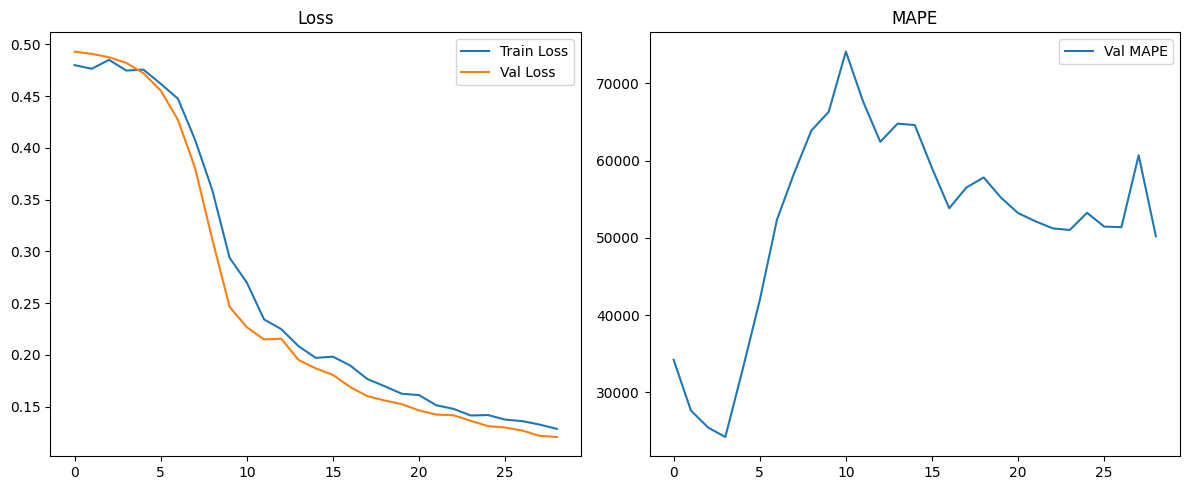

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_percentage_error
from tabm import TabM
import matplotlib.pyplot as plt
import logging
import warnings

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


class Config:
    BATCH_SIZE = 512
    LEARNING_RATE = 5e-4
    EPOCHS = 300
    EARLY_STOPPING_PATIENCE = 25
    K_ENSEMBLE = 64
    WEIGHT_DECAY = 1e-4
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    WARMUP_EPOCHS = 10


class FuelBlendDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()


class TabMTrainer:
    def __init__(self, config=Config()):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        logger.info(f"Using device: {self.device}")
        self.X_scaler = RobustScaler()
        self.y_scaler = RobustScaler()
        self.train_losses = []
        self.val_losses = []
        self.val_mapes = []
        self.feature_cols = None
        self.target_cols = None

    def feature_engineering(self, df, fit=True):
        print("Starting feature engineering...")

        if fit:
            corr_matrix = df.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
            df = df.drop(columns=to_drop)
            print(f"Dropped {len(to_drop)} highly correlated features.")

            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            for i in range(min(5, len(num_cols))):
                for j in range(i + 1, min(5, len(num_cols))):
                    df[f'inter_{num_cols[i]}_{num_cols[j]}'] = df[num_cols[i]] * df[num_cols[j]]

            # Enforce 10 target columns
            expected_targets = [f'BlendProperty{i}' for i in range(1, 11)]
            existing_targets = [col for col in df.columns if col.startswith('BlendProperty')]
            for col in expected_targets:
                if col not in df.columns:
                    df[col] = 0.0  # Fill missing targets with 0
            self.target_cols = expected_targets
            self.feature_cols = [col for col in df.columns if col not in self.target_cols]
        else:
            df = df.reindex(columns=self.feature_cols + self.target_cols, fill_value=0)

        print(f"Feature engineering done. Shape: {df.shape}")
        return df

    def load_and_prepare_data(self, train_path='train.csv', test_path='test.csv'):
        logger.info("Loading CSVs...")
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        print("Running feature engineering on training data...")
        train_df = self.feature_engineering(train_df, fit=True)

        print("Running feature engineering on test data...")
        test_df = self.feature_engineering(test_df, fit=False)

        X = train_df[self.feature_cols].values
        y = train_df[self.target_cols].values
        X_test = test_df[self.feature_cols].values
        self.test_ids = test_df.iloc[:, 0].values

        print(f"Train X shape: {X.shape} | y shape: {y.shape} | Test X shape: {X_test.shape}")

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=self.config.TEST_SIZE, random_state=self.config.RANDOM_STATE
        )

        X_train = self.X_scaler.fit_transform(X_train)
        X_val = self.X_scaler.transform(X_val)
        X_test = self.X_scaler.transform(X_test)

        y_train_scaled = self.y_scaler.fit_transform(y_train)
        y_val_scaled = self.y_scaler.transform(y_val)

        self.y_train_orig = y_train
        self.y_val_orig = y_val

        self.train_loader = DataLoader(FuelBlendDataset(X_train, y_train_scaled),
                                       batch_size=self.config.BATCH_SIZE, shuffle=True)
        self.val_loader = DataLoader(FuelBlendDataset(X_val, y_val_scaled),
                                     batch_size=self.config.BATCH_SIZE, shuffle=False)
        self.test_loader = DataLoader(FuelBlendDataset(X_test),
                                      batch_size=self.config.BATCH_SIZE, shuffle=False)
        print("Data loaders created.")

    def create_model(self):
        self.model = TabM.make(
            n_num_features=self.train_loader.dataset.X.shape[1],
            cat_cardinalities=None,
            d_out=len(self.target_cols),
            k=self.config.K_ENSEMBLE
        )
        self.model.to(self.device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config.LEARNING_RATE,
                                     weight_decay=self.config.WEIGHT_DECAY)
        self.warmup_scheduler = optim.lr_scheduler.LinearLR(self.optimizer, start_factor=0.1,
                                                            total_iters=self.config.WARMUP_EPOCHS)
        self.main_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.7, patience=8)
        self.criterion_mse = nn.MSELoss()
        print(f"Model created. Total parameters: {sum(p.numel() for p in self.model.parameters())}")

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for batch_idx, (X, y) in enumerate(self.train_loader):
            X, y = X.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            preds = self.model(X)
            preds_median = torch.median(preds, dim=1)[0]
            loss = self.criterion_mse(preds_median, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        preds_all, targets_all = [], []

        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                loss = self.criterion_mse(preds_median, y)
                total_loss += loss.item()
                preds_all.append(preds_median.cpu().numpy())
                targets_all.append(y.cpu().numpy())

        preds_all = np.vstack(preds_all)
        targets_all = np.vstack(targets_all)
        preds_orig = self.y_scaler.inverse_transform(preds_all)
        targets_orig = self.y_scaler.inverse_transform(targets_all)
        mape = np.mean(np.abs((targets_orig - preds_orig) / (np.abs(targets_orig) + 1e-6))) * 100
        return total_loss / len(self.val_loader), mape

    def train(self):
        early_stopping = EarlyStopping(patience=self.config.EARLY_STOPPING_PATIENCE)
        best_mape = float('inf')

        for epoch in range(self.config.EPOCHS):
            train_loss = self.train_epoch(epoch)
            if epoch < self.config.WARMUP_EPOCHS:
                self.warmup_scheduler.step()
            else:
                self.main_scheduler.step(train_loss)

            val_loss, val_mape = self.validate()
            print(f"Epoch {epoch+1}/{self.config.EPOCHS} | Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val MAPE: {val_mape:.2f}%")

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_mapes.append(val_mape)

            if val_mape < best_mape:
                best_mape = val_mape
                torch.save(self.model.state_dict(), 'best_tabm_model.pth')
                print(f"New best model saved with Val MAPE: {val_mape:.2f}%")

            if early_stopping(val_mape, self.model):
                print("Early stopping triggered.")
                break

        self.model.load_state_dict(torch.load('best_tabm_model.pth'))
        print("Best model loaded.")

    def predict(self):
        self.model.eval()
        preds_all = []

        with torch.no_grad():
            for X in self.test_loader:
                X = X.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                preds_all.append(preds_median.cpu().numpy())

        preds_all = np.vstack(preds_all)
        preds_orig = self.y_scaler.inverse_transform(preds_all)

        submission = pd.DataFrame(preds_orig, columns=self.target_cols)
        submission.insert(0, 'ID', self.test_ids)
        submission.to_csv('submission.csv', index=False)
        print("Submission saved to submission.csv")

    def plot_training_history(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.legend()
        plt.title("Loss")

        plt.subplot(1, 2, 2)
        plt.plot(self.val_mapes, label='Val MAPE')
        plt.legend()
        plt.title("MAPE")
        plt.tight_layout()
        plt.show()


def main():
    trainer = TabMTrainer()
    trainer.load_and_prepare_data()
    trainer.create_model()
    trainer.train()
    trainer.predict()
    trainer.plot_training_history()


if __name__ == "__main__":
    main()


In [15]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tabm import TabM  # Ensure TabM is installed and imported

# ------------------------------ Config ------------------------------

class Config:
    TRAIN_PATH = 'train.csv'
    TEST_PATH = 'test.csv'
    TARGET_COLS = [f'BlendProperty{i}' for i in range(1, 11)]
    TEST_SIZE = 0.1
    BATCH_SIZE = 512
    LR = 1e-3
    EPOCHS = 300
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    K_ENSEMBLE = 64
    RANDOM_STATE = 42

# ------------------------------ Dataset ------------------------------

class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

# ------------------------------ Trainer ------------------------------

class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.criterion_mse = nn.MSELoss()
        self.load_and_prepare_data()
        self.create_model()

    def load_and_prepare_data(self):
        train_df = pd.read_csv(self.config.TRAIN_PATH)
        test_df = pd.read_csv(self.config.TEST_PATH)
        train_df = self.feature_engineering(train_df, fit=True)
        test_df = self.feature_engineering(test_df, fit=False)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            train_df.drop(columns=self.target_cols).values,
            train_df[self.target_cols].values,
            test_size=self.config.TEST_SIZE,
            random_state=self.config.RANDOM_STATE
        )

        self.X_test = test_df.drop(columns=self.target_cols, errors='ignore').values
        self.test_ids = test_df['ID'].values if 'ID' in test_df.columns else np.arange(len(test_df))

        self.num_scaler = RobustScaler()
        self.y_scaler = RobustScaler()

        self.X_train = self.num_scaler.fit_transform(self.X_train)
        self.X_val = self.num_scaler.transform(self.X_val)
        self.X_test = self.num_scaler.transform(self.X_test)

        self.y_train = self.y_scaler.fit_transform(self.y_train)
        self.y_val = self.y_scaler.transform(self.y_val)

        self.train_loader = DataLoader(TabularDataset(self.X_train, self.y_train), batch_size=self.config.BATCH_SIZE, shuffle=True)
        self.val_loader = DataLoader(TabularDataset(self.X_val, self.y_val), batch_size=self.config.BATCH_SIZE, shuffle=False)
        self.test_loader = DataLoader(TabularDataset(self.X_test), batch_size=self.config.BATCH_SIZE, shuffle=False)

    def feature_engineering(self, df, fit=False):
        df = df.copy()
        
        # Ensure all target columns exist — fill missing with zeros
        for col in Config.TARGET_COLS:
            if col not in df.columns:
                df[col] = 0

        # Drop identifier columns if present (e.g. 'ID', 'BlendID')
        id_cols = ['ID', 'BlendID']
        df.drop(columns=[col for col in id_cols if col in df.columns], inplace=True)

        if fit:
            # Determine feature columns during training
            self.feature_cols = [col for col in df.columns if col not in Config.TARGET_COLS]
            self.target_cols = Config.TARGET_COLS

        # Ensure consistent column ordering
        df = df[self.feature_cols + self.target_cols]

        return df


    def create_model(self):
        self.model = TabM.make(
            n_num_features=self.train_loader.dataset.X.shape[1],
            cat_cardinalities=None,
            d_out=len(self.target_cols),
            k=self.config.K_ENSEMBLE
        ).to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.config.LR)

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for X, y in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.EPOCHS}"):
            X, y = X.to(self.device), y.to(self.device)
            preds = self.model(X)
            preds_median = torch.median(preds, dim=1)[0]
            loss = self.criterion_mse(preds_median, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                loss = self.criterion_mse(preds_median, y)
                total_loss += loss.item()

                all_preds.append(preds_median.cpu().numpy())
                all_targets.append(y.cpu().numpy())

        preds_all = np.vstack(all_preds)
        targets_all = np.vstack(all_targets)

        preds_all_orig = self.y_scaler.inverse_transform(preds_all)
        targets_all_orig = self.y_scaler.inverse_transform(targets_all)
        mape = mean_absolute_percentage_error(targets_all_orig, preds_all_orig) * 100

        return total_loss / len(self.val_loader), mape

    def train(self):
        for epoch in range(self.config.EPOCHS):
            train_loss = self.train_epoch(epoch)
            val_loss, val_mape = self.validate()
            print(f"Epoch {epoch+1}/{self.config.EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAPE: {val_mape:.2f}%")

    def predict(self):
        self.model.eval()
        preds_all = []

        with torch.no_grad():
            for X in self.test_loader:
                X = X.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                preds_all.append(preds_median.cpu().numpy())

        preds_all = np.vstack(preds_all)
        preds_orig = self.y_scaler.inverse_transform(preds_all)

        submission = pd.DataFrame(preds_orig, columns=self.target_cols)
        submission.insert(0, 'ID', self.test_ids)
        submission.to_csv('submission.csv', index=False)
        print("✅ Submission saved to submission.csv")

# ------------------------------ Run ------------------------------

if __name__ == '__main__':
    config = Config()
    trainer = Trainer(config)
    trainer.train()
    trainer.predict()


Epoch 1/300: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 1/300 | Train Loss: 0.5426 | Val Loss: 0.5415 | Val MAPE: 136.61%


Epoch 2/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 2/300 | Train Loss: 0.5329 | Val Loss: 0.5290 | Val MAPE: 123.50%


Epoch 3/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 3/300 | Train Loss: 0.5196 | Val Loss: 0.5056 | Val MAPE: 173.00%


Epoch 4/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 4/300 | Train Loss: 0.4837 | Val Loss: 0.4414 | Val MAPE: 222.72%


Epoch 5/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 5/300 | Train Loss: 0.3903 | Val Loss: 0.3231 | Val MAPE: 346.53%


Epoch 6/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 6/300 | Train Loss: 0.2736 | Val Loss: 0.2737 | Val MAPE: 1009.66%


Epoch 7/300: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 7/300 | Train Loss: 0.2445 | Val Loss: 0.2466 | Val MAPE: 623.73%


Epoch 8/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 8/300 | Train Loss: 0.2183 | Val Loss: 0.2239 | Val MAPE: 740.62%


Epoch 9/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 9/300 | Train Loss: 0.1909 | Val Loss: 0.1997 | Val MAPE: 1400.96%


Epoch 10/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 10/300 | Train Loss: 0.1716 | Val Loss: 0.1714 | Val MAPE: 1269.34%


Epoch 11/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 11/300 | Train Loss: 0.1519 | Val Loss: 0.1582 | Val MAPE: 560.45%


Epoch 12/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 12/300 | Train Loss: 0.1397 | Val Loss: 0.1504 | Val MAPE: 480.27%


Epoch 13/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 13/300 | Train Loss: 0.1263 | Val Loss: 0.1415 | Val MAPE: 397.54%


Epoch 14/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 14/300 | Train Loss: 0.1159 | Val Loss: 0.1324 | Val MAPE: 612.28%


Epoch 15/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 15/300 | Train Loss: 0.1097 | Val Loss: 0.1251 | Val MAPE: 581.91%


Epoch 16/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 16/300 | Train Loss: 0.1033 | Val Loss: 0.1214 | Val MAPE: 510.30%


Epoch 17/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 17/300 | Train Loss: 0.0956 | Val Loss: 0.1215 | Val MAPE: 258.60%


Epoch 18/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 18/300 | Train Loss: 0.0900 | Val Loss: 0.1124 | Val MAPE: 431.58%


Epoch 19/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 19/300 | Train Loss: 0.0847 | Val Loss: 0.1124 | Val MAPE: 336.01%


Epoch 20/300: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 20/300 | Train Loss: 0.0788 | Val Loss: 0.1075 | Val MAPE: 327.49%


Epoch 21/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 21/300 | Train Loss: 0.0748 | Val Loss: 0.1034 | Val MAPE: 245.22%


Epoch 22/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 22/300 | Train Loss: 0.0725 | Val Loss: 0.0990 | Val MAPE: 383.00%


Epoch 23/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 23/300 | Train Loss: 0.0683 | Val Loss: 0.1016 | Val MAPE: 327.52%


Epoch 24/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 24/300 | Train Loss: 0.0644 | Val Loss: 0.0989 | Val MAPE: 461.57%


Epoch 25/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 25/300 | Train Loss: 0.0618 | Val Loss: 0.0967 | Val MAPE: 728.24%


Epoch 26/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 26/300 | Train Loss: 0.0604 | Val Loss: 0.0963 | Val MAPE: 561.87%


Epoch 27/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 27/300 | Train Loss: 0.0582 | Val Loss: 0.0940 | Val MAPE: 299.99%


Epoch 28/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 28/300 | Train Loss: 0.0566 | Val Loss: 0.0948 | Val MAPE: 500.15%


Epoch 29/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 29/300 | Train Loss: 0.0531 | Val Loss: 0.0935 | Val MAPE: 292.26%


Epoch 30/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 30/300 | Train Loss: 0.0510 | Val Loss: 0.0890 | Val MAPE: 468.67%


Epoch 31/300: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


Epoch 31/300 | Train Loss: 0.0503 | Val Loss: 0.0929 | Val MAPE: 936.77%


Epoch 32/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 32/300 | Train Loss: 0.0484 | Val Loss: 0.0900 | Val MAPE: 864.52%


Epoch 33/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 33/300 | Train Loss: 0.0467 | Val Loss: 0.0882 | Val MAPE: 771.77%


Epoch 34/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 34/300 | Train Loss: 0.0455 | Val Loss: 0.0872 | Val MAPE: 325.11%


Epoch 35/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 35/300 | Train Loss: 0.0442 | Val Loss: 0.0877 | Val MAPE: 584.90%


Epoch 36/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 36/300 | Train Loss: 0.0430 | Val Loss: 0.0868 | Val MAPE: 755.42%


Epoch 37/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 37/300 | Train Loss: 0.0424 | Val Loss: 0.0879 | Val MAPE: 744.03%


Epoch 38/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 38/300 | Train Loss: 0.0410 | Val Loss: 0.0864 | Val MAPE: 484.61%


Epoch 39/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 39/300 | Train Loss: 0.0397 | Val Loss: 0.0832 | Val MAPE: 327.17%


Epoch 40/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 40/300 | Train Loss: 0.0382 | Val Loss: 0.0807 | Val MAPE: 885.39%


Epoch 41/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 41/300 | Train Loss: 0.0365 | Val Loss: 0.0805 | Val MAPE: 771.09%


Epoch 42/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 42/300 | Train Loss: 0.0364 | Val Loss: 0.0814 | Val MAPE: 831.48%


Epoch 43/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 43/300 | Train Loss: 0.0351 | Val Loss: 0.0807 | Val MAPE: 697.03%


Epoch 44/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 44/300 | Train Loss: 0.0345 | Val Loss: 0.0802 | Val MAPE: 933.39%


Epoch 45/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 45/300 | Train Loss: 0.0349 | Val Loss: 0.0797 | Val MAPE: 721.70%


Epoch 46/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 46/300 | Train Loss: 0.0335 | Val Loss: 0.0778 | Val MAPE: 530.65%


Epoch 47/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 47/300 | Train Loss: 0.0329 | Val Loss: 0.0757 | Val MAPE: 540.46%


Epoch 48/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 48/300 | Train Loss: 0.0328 | Val Loss: 0.0780 | Val MAPE: 631.86%


Epoch 49/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 49/300 | Train Loss: 0.0314 | Val Loss: 0.0776 | Val MAPE: 683.13%


Epoch 50/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 50/300 | Train Loss: 0.0307 | Val Loss: 0.0763 | Val MAPE: 991.20%


Epoch 51/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 51/300 | Train Loss: 0.0304 | Val Loss: 0.0787 | Val MAPE: 958.73%


Epoch 52/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 52/300 | Train Loss: 0.0308 | Val Loss: 0.0738 | Val MAPE: 836.95%


Epoch 53/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 53/300 | Train Loss: 0.0297 | Val Loss: 0.0742 | Val MAPE: 874.59%


Epoch 54/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 54/300 | Train Loss: 0.0287 | Val Loss: 0.0756 | Val MAPE: 795.92%


Epoch 55/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 55/300 | Train Loss: 0.0276 | Val Loss: 0.0736 | Val MAPE: 861.16%


Epoch 56/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 56/300 | Train Loss: 0.0273 | Val Loss: 0.0718 | Val MAPE: 833.84%


Epoch 57/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 57/300 | Train Loss: 0.0266 | Val Loss: 0.0726 | Val MAPE: 758.30%


Epoch 58/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 58/300 | Train Loss: 0.0264 | Val Loss: 0.0752 | Val MAPE: 861.15%


Epoch 59/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 59/300 | Train Loss: 0.0257 | Val Loss: 0.0722 | Val MAPE: 871.36%


Epoch 60/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 60/300 | Train Loss: 0.0252 | Val Loss: 0.0717 | Val MAPE: 860.49%


Epoch 61/300: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Epoch 61/300 | Train Loss: 0.0243 | Val Loss: 0.0709 | Val MAPE: 802.14%


Epoch 62/300: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 62/300 | Train Loss: 0.0247 | Val Loss: 0.0675 | Val MAPE: 937.11%


Epoch 63/300: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 63/300 | Train Loss: 0.0238 | Val Loss: 0.0694 | Val MAPE: 805.91%


Epoch 64/300: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 64/300 | Train Loss: 0.0235 | Val Loss: 0.0688 | Val MAPE: 871.57%


Epoch 65/300: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 65/300 | Train Loss: 0.0234 | Val Loss: 0.0702 | Val MAPE: 665.26%


Epoch 66/300: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch 66/300 | Train Loss: 0.0234 | Val Loss: 0.0686 | Val MAPE: 603.42%


Epoch 67/300: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch 67/300 | Train Loss: 0.0232 | Val Loss: 0.0696 | Val MAPE: 626.11%


Epoch 68/300: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Epoch 68/300 | Train Loss: 0.0221 | Val Loss: 0.0681 | Val MAPE: 702.82%


Epoch 69/300: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Epoch 69/300 | Train Loss: 0.0220 | Val Loss: 0.0702 | Val MAPE: 697.24%


Epoch 70/300: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 70/300 | Train Loss: 0.0215 | Val Loss: 0.0690 | Val MAPE: 736.90%


Epoch 71/300: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 71/300 | Train Loss: 0.0214 | Val Loss: 0.0678 | Val MAPE: 822.53%


Epoch 72/300: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 72/300 | Train Loss: 0.0213 | Val Loss: 0.0679 | Val MAPE: 663.83%


Epoch 73/300: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Epoch 73/300 | Train Loss: 0.0210 | Val Loss: 0.0655 | Val MAPE: 586.82%


Epoch 74/300: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 74/300 | Train Loss: 0.0203 | Val Loss: 0.0653 | Val MAPE: 465.75%


Epoch 75/300: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 75/300 | Train Loss: 0.0205 | Val Loss: 0.0641 | Val MAPE: 875.56%


Epoch 76/300: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 76/300 | Train Loss: 0.0201 | Val Loss: 0.0651 | Val MAPE: 990.56%


Epoch 77/300: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 77/300 | Train Loss: 0.0197 | Val Loss: 0.0659 | Val MAPE: 768.13%


Epoch 78/300: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Epoch 78/300 | Train Loss: 0.0197 | Val Loss: 0.0659 | Val MAPE: 866.53%


Epoch 79/300: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 79/300 | Train Loss: 0.0193 | Val Loss: 0.0645 | Val MAPE: 763.35%


Epoch 80/300: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Epoch 80/300 | Train Loss: 0.0187 | Val Loss: 0.0639 | Val MAPE: 798.55%


Epoch 81/300: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 81/300 | Train Loss: 0.0191 | Val Loss: 0.0642 | Val MAPE: 800.18%


Epoch 82/300: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 82/300 | Train Loss: 0.0186 | Val Loss: 0.0657 | Val MAPE: 808.60%


Epoch 83/300: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 83/300 | Train Loss: 0.0184 | Val Loss: 0.0622 | Val MAPE: 596.59%


Epoch 84/300: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 84/300 | Train Loss: 0.0189 | Val Loss: 0.0628 | Val MAPE: 689.66%


Epoch 85/300: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 85/300 | Train Loss: 0.0184 | Val Loss: 0.0656 | Val MAPE: 608.05%


Epoch 86/300: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 86/300 | Train Loss: 0.0179 | Val Loss: 0.0645 | Val MAPE: 601.03%


Epoch 87/300: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 87/300 | Train Loss: 0.0173 | Val Loss: 0.0632 | Val MAPE: 457.86%


Epoch 88/300: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 88/300 | Train Loss: 0.0174 | Val Loss: 0.0644 | Val MAPE: 557.79%


Epoch 89/300: 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 89/300 | Train Loss: 0.0166 | Val Loss: 0.0647 | Val MAPE: 624.34%


Epoch 90/300: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch 90/300 | Train Loss: 0.0170 | Val Loss: 0.0652 | Val MAPE: 428.45%


Epoch 91/300: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 91/300 | Train Loss: 0.0168 | Val Loss: 0.0641 | Val MAPE: 510.46%


Epoch 92/300: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 92/300 | Train Loss: 0.0169 | Val Loss: 0.0621 | Val MAPE: 635.27%


Epoch 93/300: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 93/300 | Train Loss: 0.0166 | Val Loss: 0.0623 | Val MAPE: 534.11%


Epoch 94/300: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Epoch 94/300 | Train Loss: 0.0165 | Val Loss: 0.0623 | Val MAPE: 425.75%


Epoch 95/300: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 95/300 | Train Loss: 0.0162 | Val Loss: 0.0618 | Val MAPE: 637.14%


Epoch 96/300: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 96/300 | Train Loss: 0.0166 | Val Loss: 0.0595 | Val MAPE: 726.33%


Epoch 97/300: 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 97/300 | Train Loss: 0.0163 | Val Loss: 0.0596 | Val MAPE: 612.75%


Epoch 98/300: 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 98/300 | Train Loss: 0.0159 | Val Loss: 0.0587 | Val MAPE: 580.90%


Epoch 99/300: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 99/300 | Train Loss: 0.0155 | Val Loss: 0.0590 | Val MAPE: 725.82%


Epoch 100/300: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 100/300 | Train Loss: 0.0156 | Val Loss: 0.0597 | Val MAPE: 660.30%


Epoch 101/300: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Epoch 101/300 | Train Loss: 0.0152 | Val Loss: 0.0598 | Val MAPE: 671.77%


Epoch 102/300: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 102/300 | Train Loss: 0.0152 | Val Loss: 0.0592 | Val MAPE: 535.00%


Epoch 103/300: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Epoch 103/300 | Train Loss: 0.0151 | Val Loss: 0.0579 | Val MAPE: 449.90%


Epoch 104/300: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 104/300 | Train Loss: 0.0150 | Val Loss: 0.0576 | Val MAPE: 522.78%


Epoch 105/300: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Epoch 105/300 | Train Loss: 0.0150 | Val Loss: 0.0589 | Val MAPE: 575.58%


Epoch 106/300: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 106/300 | Train Loss: 0.0151 | Val Loss: 0.0585 | Val MAPE: 571.38%


Epoch 107/300: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 107/300 | Train Loss: 0.0143 | Val Loss: 0.0603 | Val MAPE: 599.55%


Epoch 108/300: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 108/300 | Train Loss: 0.0147 | Val Loss: 0.0598 | Val MAPE: 643.94%


Epoch 109/300: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Epoch 109/300 | Train Loss: 0.0147 | Val Loss: 0.0579 | Val MAPE: 452.04%


Epoch 110/300: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Epoch 110/300 | Train Loss: 0.0145 | Val Loss: 0.0579 | Val MAPE: 668.13%


Epoch 111/300: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Epoch 111/300 | Train Loss: 0.0142 | Val Loss: 0.0596 | Val MAPE: 653.74%


Epoch 112/300: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


Epoch 112/300 | Train Loss: 0.0148 | Val Loss: 0.0578 | Val MAPE: 583.34%


Epoch 113/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 113/300 | Train Loss: 0.0139 | Val Loss: 0.0574 | Val MAPE: 718.51%


Epoch 114/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 114/300 | Train Loss: 0.0142 | Val Loss: 0.0577 | Val MAPE: 365.10%


Epoch 115/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 115/300 | Train Loss: 0.0137 | Val Loss: 0.0581 | Val MAPE: 465.65%


Epoch 116/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 116/300 | Train Loss: 0.0137 | Val Loss: 0.0579 | Val MAPE: 410.43%


Epoch 117/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 117/300 | Train Loss: 0.0137 | Val Loss: 0.0586 | Val MAPE: 580.21%


Epoch 118/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 118/300 | Train Loss: 0.0134 | Val Loss: 0.0589 | Val MAPE: 451.38%


Epoch 119/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 119/300 | Train Loss: 0.0136 | Val Loss: 0.0580 | Val MAPE: 487.15%


Epoch 120/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 120/300 | Train Loss: 0.0132 | Val Loss: 0.0588 | Val MAPE: 318.15%


Epoch 121/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 121/300 | Train Loss: 0.0132 | Val Loss: 0.0593 | Val MAPE: 352.01%


Epoch 122/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 122/300 | Train Loss: 0.0130 | Val Loss: 0.0590 | Val MAPE: 449.50%


Epoch 123/300: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch 123/300 | Train Loss: 0.0129 | Val Loss: 0.0583 | Val MAPE: 513.98%


Epoch 124/300: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 124/300 | Train Loss: 0.0133 | Val Loss: 0.0570 | Val MAPE: 433.06%


Epoch 125/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 125/300 | Train Loss: 0.0130 | Val Loss: 0.0568 | Val MAPE: 662.90%


Epoch 126/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 126/300 | Train Loss: 0.0128 | Val Loss: 0.0559 | Val MAPE: 561.64%


Epoch 127/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 127/300 | Train Loss: 0.0129 | Val Loss: 0.0569 | Val MAPE: 622.63%


Epoch 128/300: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 128/300 | Train Loss: 0.0125 | Val Loss: 0.0567 | Val MAPE: 457.66%


Epoch 129/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 129/300 | Train Loss: 0.0124 | Val Loss: 0.0564 | Val MAPE: 523.95%


Epoch 130/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 130/300 | Train Loss: 0.0126 | Val Loss: 0.0579 | Val MAPE: 573.38%


Epoch 131/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 131/300 | Train Loss: 0.0124 | Val Loss: 0.0566 | Val MAPE: 731.03%


Epoch 132/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 132/300 | Train Loss: 0.0123 | Val Loss: 0.0566 | Val MAPE: 671.79%


Epoch 133/300: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 133/300 | Train Loss: 0.0122 | Val Loss: 0.0567 | Val MAPE: 587.42%


Epoch 134/300: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 134/300 | Train Loss: 0.0121 | Val Loss: 0.0573 | Val MAPE: 647.50%


Epoch 135/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 135/300 | Train Loss: 0.0122 | Val Loss: 0.0590 | Val MAPE: 560.01%


Epoch 136/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 136/300 | Train Loss: 0.0118 | Val Loss: 0.0572 | Val MAPE: 516.55%


Epoch 137/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 137/300 | Train Loss: 0.0122 | Val Loss: 0.0559 | Val MAPE: 549.23%


Epoch 138/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 138/300 | Train Loss: 0.0116 | Val Loss: 0.0557 | Val MAPE: 605.93%


Epoch 139/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 139/300 | Train Loss: 0.0117 | Val Loss: 0.0563 | Val MAPE: 707.15%


Epoch 140/300: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 140/300 | Train Loss: 0.0118 | Val Loss: 0.0569 | Val MAPE: 488.68%


Epoch 141/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 141/300 | Train Loss: 0.0121 | Val Loss: 0.0557 | Val MAPE: 469.00%


Epoch 142/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 142/300 | Train Loss: 0.0120 | Val Loss: 0.0554 | Val MAPE: 432.57%


Epoch 143/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 143/300 | Train Loss: 0.0117 | Val Loss: 0.0567 | Val MAPE: 454.78%


Epoch 144/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 144/300 | Train Loss: 0.0119 | Val Loss: 0.0554 | Val MAPE: 344.72%


Epoch 145/300: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch 145/300 | Train Loss: 0.0119 | Val Loss: 0.0573 | Val MAPE: 600.88%


Epoch 146/300: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 146/300 | Train Loss: 0.0116 | Val Loss: 0.0569 | Val MAPE: 490.51%


Epoch 147/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 147/300 | Train Loss: 0.0115 | Val Loss: 0.0570 | Val MAPE: 611.30%


Epoch 148/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 148/300 | Train Loss: 0.0116 | Val Loss: 0.0565 | Val MAPE: 169.80%


Epoch 149/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 149/300 | Train Loss: 0.0114 | Val Loss: 0.0563 | Val MAPE: 268.99%


Epoch 150/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 150/300 | Train Loss: 0.0112 | Val Loss: 0.0562 | Val MAPE: 439.51%


Epoch 151/300: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch 151/300 | Train Loss: 0.0115 | Val Loss: 0.0558 | Val MAPE: 563.69%


Epoch 152/300: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Epoch 152/300 | Train Loss: 0.0113 | Val Loss: 0.0566 | Val MAPE: 434.52%


Epoch 153/300: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Epoch 153/300 | Train Loss: 0.0108 | Val Loss: 0.0550 | Val MAPE: 523.06%


Epoch 154/300: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 154/300 | Train Loss: 0.0111 | Val Loss: 0.0557 | Val MAPE: 510.40%


Epoch 155/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 155/300 | Train Loss: 0.0109 | Val Loss: 0.0567 | Val MAPE: 494.02%


Epoch 156/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 156/300 | Train Loss: 0.0110 | Val Loss: 0.0567 | Val MAPE: 342.07%


Epoch 157/300: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 157/300 | Train Loss: 0.0110 | Val Loss: 0.0549 | Val MAPE: 170.60%


Epoch 158/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 158/300 | Train Loss: 0.0109 | Val Loss: 0.0553 | Val MAPE: 289.35%


Epoch 159/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 159/300 | Train Loss: 0.0107 | Val Loss: 0.0548 | Val MAPE: 478.22%


Epoch 160/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 160/300 | Train Loss: 0.0108 | Val Loss: 0.0552 | Val MAPE: 385.93%


Epoch 161/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 161/300 | Train Loss: 0.0105 | Val Loss: 0.0553 | Val MAPE: 382.19%


Epoch 162/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 162/300 | Train Loss: 0.0105 | Val Loss: 0.0550 | Val MAPE: 430.65%


Epoch 163/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 163/300 | Train Loss: 0.0106 | Val Loss: 0.0550 | Val MAPE: 406.64%


Epoch 164/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 164/300 | Train Loss: 0.0103 | Val Loss: 0.0544 | Val MAPE: 453.22%


Epoch 165/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 165/300 | Train Loss: 0.0105 | Val Loss: 0.0553 | Val MAPE: 347.70%


Epoch 166/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 166/300 | Train Loss: 0.0107 | Val Loss: 0.0547 | Val MAPE: 531.87%


Epoch 167/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 167/300 | Train Loss: 0.0102 | Val Loss: 0.0538 | Val MAPE: 518.98%


Epoch 168/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 168/300 | Train Loss: 0.0102 | Val Loss: 0.0557 | Val MAPE: 612.19%


Epoch 169/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 169/300 | Train Loss: 0.0104 | Val Loss: 0.0550 | Val MAPE: 476.38%


Epoch 170/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 170/300 | Train Loss: 0.0102 | Val Loss: 0.0541 | Val MAPE: 484.51%


Epoch 171/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 171/300 | Train Loss: 0.0101 | Val Loss: 0.0551 | Val MAPE: 470.56%


Epoch 172/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 172/300 | Train Loss: 0.0100 | Val Loss: 0.0537 | Val MAPE: 511.76%


Epoch 173/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 173/300 | Train Loss: 0.0102 | Val Loss: 0.0536 | Val MAPE: 356.10%


Epoch 174/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 174/300 | Train Loss: 0.0101 | Val Loss: 0.0530 | Val MAPE: 319.20%


Epoch 175/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 175/300 | Train Loss: 0.0101 | Val Loss: 0.0531 | Val MAPE: 588.75%


Epoch 176/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 176/300 | Train Loss: 0.0101 | Val Loss: 0.0526 | Val MAPE: 558.90%


Epoch 177/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 177/300 | Train Loss: 0.0100 | Val Loss: 0.0526 | Val MAPE: 559.36%


Epoch 178/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 178/300 | Train Loss: 0.0100 | Val Loss: 0.0528 | Val MAPE: 533.67%


Epoch 179/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 179/300 | Train Loss: 0.0100 | Val Loss: 0.0529 | Val MAPE: 389.85%


Epoch 180/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 180/300 | Train Loss: 0.0098 | Val Loss: 0.0527 | Val MAPE: 350.22%


Epoch 181/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 181/300 | Train Loss: 0.0096 | Val Loss: 0.0534 | Val MAPE: 432.54%


Epoch 182/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 182/300 | Train Loss: 0.0097 | Val Loss: 0.0536 | Val MAPE: 402.69%


Epoch 183/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 183/300 | Train Loss: 0.0098 | Val Loss: 0.0536 | Val MAPE: 530.43%


Epoch 184/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 184/300 | Train Loss: 0.0099 | Val Loss: 0.0547 | Val MAPE: 526.08%


Epoch 185/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 185/300 | Train Loss: 0.0095 | Val Loss: 0.0553 | Val MAPE: 527.45%


Epoch 186/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 186/300 | Train Loss: 0.0093 | Val Loss: 0.0557 | Val MAPE: 346.58%


Epoch 187/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 187/300 | Train Loss: 0.0095 | Val Loss: 0.0557 | Val MAPE: 340.81%


Epoch 188/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 188/300 | Train Loss: 0.0096 | Val Loss: 0.0542 | Val MAPE: 320.62%


Epoch 189/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 189/300 | Train Loss: 0.0096 | Val Loss: 0.0526 | Val MAPE: 128.89%


Epoch 190/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 190/300 | Train Loss: 0.0095 | Val Loss: 0.0532 | Val MAPE: 104.75%


Epoch 191/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 191/300 | Train Loss: 0.0093 | Val Loss: 0.0533 | Val MAPE: 203.72%


Epoch 192/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 192/300 | Train Loss: 0.0094 | Val Loss: 0.0514 | Val MAPE: 342.49%


Epoch 193/300: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 193/300 | Train Loss: 0.0092 | Val Loss: 0.0519 | Val MAPE: 353.07%


Epoch 194/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 194/300 | Train Loss: 0.0093 | Val Loss: 0.0521 | Val MAPE: 254.11%


Epoch 195/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 195/300 | Train Loss: 0.0095 | Val Loss: 0.0542 | Val MAPE: 181.70%


Epoch 196/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 196/300 | Train Loss: 0.0092 | Val Loss: 0.0552 | Val MAPE: 103.71%


Epoch 197/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 197/300 | Train Loss: 0.0091 | Val Loss: 0.0547 | Val MAPE: 202.28%


Epoch 198/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 198/300 | Train Loss: 0.0090 | Val Loss: 0.0530 | Val MAPE: 227.07%


Epoch 199/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 199/300 | Train Loss: 0.0091 | Val Loss: 0.0523 | Val MAPE: 398.16%


Epoch 200/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 200/300 | Train Loss: 0.0089 | Val Loss: 0.0536 | Val MAPE: 453.28%


Epoch 201/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 201/300 | Train Loss: 0.0091 | Val Loss: 0.0543 | Val MAPE: 419.34%


Epoch 202/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 202/300 | Train Loss: 0.0090 | Val Loss: 0.0536 | Val MAPE: 286.75%


Epoch 203/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 203/300 | Train Loss: 0.0090 | Val Loss: 0.0525 | Val MAPE: 334.40%


Epoch 204/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 204/300 | Train Loss: 0.0089 | Val Loss: 0.0525 | Val MAPE: 366.29%


Epoch 205/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 205/300 | Train Loss: 0.0087 | Val Loss: 0.0511 | Val MAPE: 244.11%


Epoch 206/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 206/300 | Train Loss: 0.0089 | Val Loss: 0.0511 | Val MAPE: 405.38%


Epoch 207/300: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 207/300 | Train Loss: 0.0090 | Val Loss: 0.0508 | Val MAPE: 405.75%


Epoch 208/300: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 208/300 | Train Loss: 0.0089 | Val Loss: 0.0529 | Val MAPE: 469.22%


Epoch 209/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 209/300 | Train Loss: 0.0088 | Val Loss: 0.0540 | Val MAPE: 391.98%


Epoch 210/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 210/300 | Train Loss: 0.0087 | Val Loss: 0.0532 | Val MAPE: 384.54%


Epoch 211/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 211/300 | Train Loss: 0.0089 | Val Loss: 0.0519 | Val MAPE: 370.56%


Epoch 212/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 212/300 | Train Loss: 0.0089 | Val Loss: 0.0513 | Val MAPE: 348.88%


Epoch 213/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 213/300 | Train Loss: 0.0087 | Val Loss: 0.0514 | Val MAPE: 301.78%


Epoch 214/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 214/300 | Train Loss: 0.0087 | Val Loss: 0.0515 | Val MAPE: 313.40%


Epoch 215/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 215/300 | Train Loss: 0.0086 | Val Loss: 0.0515 | Val MAPE: 296.63%


Epoch 216/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 216/300 | Train Loss: 0.0085 | Val Loss: 0.0521 | Val MAPE: 258.45%


Epoch 217/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 217/300 | Train Loss: 0.0088 | Val Loss: 0.0520 | Val MAPE: 230.79%


Epoch 218/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 218/300 | Train Loss: 0.0083 | Val Loss: 0.0518 | Val MAPE: 347.69%


Epoch 219/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 219/300 | Train Loss: 0.0084 | Val Loss: 0.0515 | Val MAPE: 304.30%


Epoch 220/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 220/300 | Train Loss: 0.0086 | Val Loss: 0.0520 | Val MAPE: 247.44%


Epoch 221/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 221/300 | Train Loss: 0.0085 | Val Loss: 0.0516 | Val MAPE: 279.66%


Epoch 222/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 222/300 | Train Loss: 0.0084 | Val Loss: 0.0517 | Val MAPE: 242.50%


Epoch 223/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 223/300 | Train Loss: 0.0086 | Val Loss: 0.0535 | Val MAPE: 326.11%


Epoch 224/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 224/300 | Train Loss: 0.0084 | Val Loss: 0.0531 | Val MAPE: 230.48%


Epoch 225/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 225/300 | Train Loss: 0.0085 | Val Loss: 0.0540 | Val MAPE: 354.99%


Epoch 226/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 226/300 | Train Loss: 0.0085 | Val Loss: 0.0522 | Val MAPE: 329.09%


Epoch 227/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 227/300 | Train Loss: 0.0086 | Val Loss: 0.0522 | Val MAPE: 482.24%


Epoch 228/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 228/300 | Train Loss: 0.0086 | Val Loss: 0.0543 | Val MAPE: 267.43%


Epoch 229/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 229/300 | Train Loss: 0.0084 | Val Loss: 0.0527 | Val MAPE: 201.17%


Epoch 230/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 230/300 | Train Loss: 0.0084 | Val Loss: 0.0521 | Val MAPE: 104.11%


Epoch 231/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 231/300 | Train Loss: 0.0084 | Val Loss: 0.0527 | Val MAPE: 195.63%


Epoch 232/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 232/300 | Train Loss: 0.0081 | Val Loss: 0.0513 | Val MAPE: 167.60%


Epoch 233/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 233/300 | Train Loss: 0.0081 | Val Loss: 0.0525 | Val MAPE: 174.28%


Epoch 234/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 234/300 | Train Loss: 0.0083 | Val Loss: 0.0510 | Val MAPE: 153.32%


Epoch 235/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 235/300 | Train Loss: 0.0081 | Val Loss: 0.0519 | Val MAPE: 176.98%


Epoch 236/300: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch 236/300 | Train Loss: 0.0082 | Val Loss: 0.0516 | Val MAPE: 275.07%


Epoch 237/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 237/300 | Train Loss: 0.0078 | Val Loss: 0.0507 | Val MAPE: 263.63%


Epoch 238/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 238/300 | Train Loss: 0.0080 | Val Loss: 0.0511 | Val MAPE: 404.26%


Epoch 239/300: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch 239/300 | Train Loss: 0.0079 | Val Loss: 0.0501 | Val MAPE: 379.80%


Epoch 240/300: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 240/300 | Train Loss: 0.0080 | Val Loss: 0.0512 | Val MAPE: 291.37%


Epoch 241/300: 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


Epoch 241/300 | Train Loss: 0.0080 | Val Loss: 0.0510 | Val MAPE: 93.41%


Epoch 242/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 242/300 | Train Loss: 0.0079 | Val Loss: 0.0517 | Val MAPE: 228.88%


Epoch 243/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 243/300 | Train Loss: 0.0078 | Val Loss: 0.0502 | Val MAPE: 206.17%


Epoch 244/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 244/300 | Train Loss: 0.0078 | Val Loss: 0.0509 | Val MAPE: 390.55%


Epoch 245/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 245/300 | Train Loss: 0.0079 | Val Loss: 0.0504 | Val MAPE: 403.94%


Epoch 246/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 246/300 | Train Loss: 0.0077 | Val Loss: 0.0512 | Val MAPE: 415.20%


Epoch 247/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 247/300 | Train Loss: 0.0078 | Val Loss: 0.0511 | Val MAPE: 265.46%


Epoch 248/300: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 248/300 | Train Loss: 0.0077 | Val Loss: 0.0520 | Val MAPE: 144.77%


Epoch 249/300: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


Epoch 249/300 | Train Loss: 0.0077 | Val Loss: 0.0527 | Val MAPE: 92.70%


Epoch 250/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 250/300 | Train Loss: 0.0076 | Val Loss: 0.0520 | Val MAPE: 270.77%


Epoch 251/300: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 251/300 | Train Loss: 0.0077 | Val Loss: 0.0532 | Val MAPE: 435.58%


Epoch 252/300: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 252/300 | Train Loss: 0.0078 | Val Loss: 0.0522 | Val MAPE: 362.08%


Epoch 253/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 253/300 | Train Loss: 0.0076 | Val Loss: 0.0523 | Val MAPE: 299.01%


Epoch 254/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 254/300 | Train Loss: 0.0077 | Val Loss: 0.0525 | Val MAPE: 181.30%


Epoch 255/300: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 255/300 | Train Loss: 0.0078 | Val Loss: 0.0518 | Val MAPE: 144.69%


Epoch 256/300: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 256/300 | Train Loss: 0.0075 | Val Loss: 0.0508 | Val MAPE: 258.65%


Epoch 257/300: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


Epoch 257/300 | Train Loss: 0.0075 | Val Loss: 0.0515 | Val MAPE: 181.19%


Epoch 258/300: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 258/300 | Train Loss: 0.0078 | Val Loss: 0.0513 | Val MAPE: 272.20%


Epoch 259/300: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Epoch 259/300 | Train Loss: 0.0074 | Val Loss: 0.0524 | Val MAPE: 163.41%


Epoch 260/300: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


Epoch 260/300 | Train Loss: 0.0076 | Val Loss: 0.0522 | Val MAPE: 192.04%


Epoch 261/300: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Epoch 261/300 | Train Loss: 0.0076 | Val Loss: 0.0514 | Val MAPE: 108.34%


Epoch 262/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 262/300 | Train Loss: 0.0075 | Val Loss: 0.0516 | Val MAPE: 153.67%


Epoch 263/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 263/300 | Train Loss: 0.0075 | Val Loss: 0.0502 | Val MAPE: 157.29%


Epoch 264/300: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 264/300 | Train Loss: 0.0075 | Val Loss: 0.0497 | Val MAPE: 248.94%


Epoch 265/300: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Epoch 265/300 | Train Loss: 0.0074 | Val Loss: 0.0499 | Val MAPE: 242.52%


Epoch 266/300: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 266/300 | Train Loss: 0.0075 | Val Loss: 0.0499 | Val MAPE: 268.31%


Epoch 267/300: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Epoch 267/300 | Train Loss: 0.0075 | Val Loss: 0.0507 | Val MAPE: 304.52%


Epoch 268/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 268/300 | Train Loss: 0.0078 | Val Loss: 0.0508 | Val MAPE: 383.38%


Epoch 269/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 269/300 | Train Loss: 0.0076 | Val Loss: 0.0510 | Val MAPE: 189.40%


Epoch 270/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 270/300 | Train Loss: 0.0075 | Val Loss: 0.0506 | Val MAPE: 263.39%


Epoch 271/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 271/300 | Train Loss: 0.0077 | Val Loss: 0.0495 | Val MAPE: 258.87%


Epoch 272/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 272/300 | Train Loss: 0.0075 | Val Loss: 0.0500 | Val MAPE: 196.66%


Epoch 273/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 273/300 | Train Loss: 0.0074 | Val Loss: 0.0498 | Val MAPE: 211.97%


Epoch 274/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 274/300 | Train Loss: 0.0073 | Val Loss: 0.0488 | Val MAPE: 88.16%


Epoch 275/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 275/300 | Train Loss: 0.0073 | Val Loss: 0.0504 | Val MAPE: 194.05%


Epoch 276/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 276/300 | Train Loss: 0.0073 | Val Loss: 0.0507 | Val MAPE: 229.83%


Epoch 277/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 277/300 | Train Loss: 0.0071 | Val Loss: 0.0507 | Val MAPE: 202.58%


Epoch 278/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 278/300 | Train Loss: 0.0072 | Val Loss: 0.0500 | Val MAPE: 215.32%


Epoch 279/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 279/300 | Train Loss: 0.0070 | Val Loss: 0.0496 | Val MAPE: 238.96%


Epoch 280/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 280/300 | Train Loss: 0.0071 | Val Loss: 0.0494 | Val MAPE: 245.18%


Epoch 281/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 281/300 | Train Loss: 0.0072 | Val Loss: 0.0494 | Val MAPE: 244.57%


Epoch 282/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 282/300 | Train Loss: 0.0072 | Val Loss: 0.0501 | Val MAPE: 401.92%


Epoch 283/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 283/300 | Train Loss: 0.0071 | Val Loss: 0.0494 | Val MAPE: 303.02%


Epoch 284/300: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 284/300 | Train Loss: 0.0073 | Val Loss: 0.0489 | Val MAPE: 295.67%


Epoch 285/300: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 285/300 | Train Loss: 0.0072 | Val Loss: 0.0502 | Val MAPE: 180.27%


Epoch 286/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 286/300 | Train Loss: 0.0071 | Val Loss: 0.0482 | Val MAPE: 152.96%


Epoch 287/300: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch 287/300 | Train Loss: 0.0070 | Val Loss: 0.0477 | Val MAPE: 293.60%


Epoch 288/300: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Epoch 288/300 | Train Loss: 0.0070 | Val Loss: 0.0494 | Val MAPE: 246.90%


Epoch 289/300: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 289/300 | Train Loss: 0.0070 | Val Loss: 0.0505 | Val MAPE: 228.19%


Epoch 290/300: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 290/300 | Train Loss: 0.0071 | Val Loss: 0.0507 | Val MAPE: 112.73%


Epoch 291/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 291/300 | Train Loss: 0.0068 | Val Loss: 0.0510 | Val MAPE: 160.95%


Epoch 292/300: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 292/300 | Train Loss: 0.0068 | Val Loss: 0.0503 | Val MAPE: 195.56%


Epoch 293/300: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 293/300 | Train Loss: 0.0070 | Val Loss: 0.0499 | Val MAPE: 200.95%


Epoch 294/300: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 294/300 | Train Loss: 0.0070 | Val Loss: 0.0496 | Val MAPE: 156.49%


Epoch 295/300: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 295/300 | Train Loss: 0.0069 | Val Loss: 0.0508 | Val MAPE: 180.91%


Epoch 296/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 296/300 | Train Loss: 0.0069 | Val Loss: 0.0505 | Val MAPE: 246.62%


Epoch 297/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 297/300 | Train Loss: 0.0068 | Val Loss: 0.0496 | Val MAPE: 88.54%


Epoch 298/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 298/300 | Train Loss: 0.0069 | Val Loss: 0.0504 | Val MAPE: 155.44%


Epoch 299/300: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 299/300 | Train Loss: 0.0070 | Val Loss: 0.0483 | Val MAPE: 251.01%


Epoch 300/300: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 300/300 | Train Loss: 0.0068 | Val Loss: 0.0488 | Val MAPE: 243.57%
✅ Submission saved to submission.csv


In [42]:
pip install RobustScaler StandardScaler QuantileTransformer VarianceThreshold

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement RobustScaler (from versions: none)
ERROR: No matching distribution found for RobustScaler


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tabm import TabM  # Ensure TabM is installed and imported
import warnings
warnings.filterwarnings('ignore')

# ------------------------------ Config ------------------------------

class Config:
    TRAIN_PATH = 'train.csv'
    TEST_PATH = 'test.csv'
    TARGET_COLS = [f'BlendProperty{i}' for i in range(1, 11)]
    TEST_SIZE = 0.1
    BATCH_SIZE = 512
    LR = 1e-3
    EPOCHS = 300
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    K_ENSEMBLE = 64
    RANDOM_STATE = 42
    
    # Feature engineering parameters
    PCA_COMPONENTS = 50
    TOP_K_FEATURES = 200
    POLY_DEGREE = 2
    TOP_N_CORRELATED = 15
    CLUSTERS = 10
    VARIANCE_THRESHOLD = 0.01

    def __init__(self):
        self.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# ------------------------------ Dataset ------------------------------

class TabularDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

# ------------------------------ Trainer ------------------------------

class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.criterion_mse = nn.MSELoss()
        self.target_columns = [f'BlendProperty{i}' for i in range(1, 11)]
        self.load_and_prepare_data()
        self.create_model()

    def load_and_prepare_data(self):
        train_df = pd.read_csv(self.config.TRAIN_PATH)
        test_df = pd.read_csv(self.config.TEST_PATH)
        
        print("Original shapes:", train_df.shape, test_df.shape)
        print("Train columns:", list(train_df.columns))
        print("Test columns:", list(test_df.columns))
        
        # Check for missing values and data quality
        print("Train missing values:", train_df.isnull().sum().sum())
        print("Test missing values:", test_df.isnull().sum().sum())
        
        # Check target value ranges
        target_stats = train_df[self.config.TARGET_COLS].describe()
        print("Target statistics:")
        print(target_stats)
        
        # Identify common features (everything except targets and ID)
        train_feature_cols = [col for col in train_df.columns if col not in self.config.TARGET_COLS and col != 'ID']
        test_feature_cols = [col for col in test_df.columns if col not in self.config.TARGET_COLS and col != 'ID']
        
        # Use only features that exist in both datasets
        self.common_features = list(set(train_feature_cols) & set(test_feature_cols))
        print(f"Common features between train and test: {len(self.common_features)}")
        
        # Process train and test data together to ensure consistency
        train_df = self.feature_engineering(train_df, fit=True)
        test_df = self.feature_engineering(test_df, fit=False)
        
        print("After feature engineering:", train_df.shape, test_df.shape)
        
        # Get final feature columns (excluding targets and ID)
        final_feature_cols = [col for col in train_df.columns if col not in self.config.TARGET_COLS and col != 'ID']
        
        # Ensure test data has all required features
        for col in final_feature_cols:
            if col not in test_df.columns:
                test_df[col] = 0
                print(f"Added missing feature {col} to test data")
        
        # Reorder test columns to match training data
        test_df = test_df[['ID'] + final_feature_cols + [col for col in test_df.columns if col in self.config.TARGET_COLS]]

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            train_df[final_feature_cols].values,
            train_df[self.config.TARGET_COLS].values,
            test_size=self.config.TEST_SIZE,
            random_state=self.config.RANDOM_STATE
        )

        self.X_test = test_df[final_feature_cols].values
        self.test_ids = test_df['ID'].values

        print(f"Final shapes - Train: {self.X_train.shape}, Val: {self.X_val.shape}, Test: {self.X_test.shape}")

        # Handle extreme values and outliers before scaling
        self.X_train = np.clip(self.X_train, -1e6, 1e6)
        self.X_val = np.clip(self.X_val, -1e6, 1e6)
        self.X_test = np.clip(self.X_test, -1e6, 1e6)
        
        # Handle extreme values in targets
        self.y_train = np.clip(self.y_train, -1e6, 1e6)
        self.y_val = np.clip(self.y_val, -1e6, 1e6)

        # Store original targets for MAPE calculation
        self.y_train_orig = self.y_train.copy()
        self.y_val_orig = self.y_val.copy()

        # Use StandardScaler for more stable scaling
        self.num_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

        self.X_train = self.num_scaler.fit_transform(self.X_train)
        self.X_val = self.num_scaler.transform(self.X_val)
        self.X_test = self.num_scaler.transform(self.X_test)

        self.y_train = self.y_scaler.fit_transform(self.y_train)
        self.y_val = self.y_scaler.transform(self.y_val)

        # Check for any remaining NaN or infinite values
        print("NaN in X_train:", np.isnan(self.X_train).sum())
        print("NaN in y_train:", np.isnan(self.y_train).sum())
        print("Inf in X_train:", np.isinf(self.X_train).sum())
        print("Inf in y_train:", np.isinf(self.y_train).sum())

        # Replace any remaining NaN or infinite values
        self.X_train = np.nan_to_num(self.X_train, nan=0.0, posinf=1e6, neginf=-1e6)
        self.X_val = np.nan_to_num(self.X_val, nan=0.0, posinf=1e6, neginf=-1e6)
        self.X_test = np.nan_to_num(self.X_test, nan=0.0, posinf=1e6, neginf=-1e6)
        self.y_train = np.nan_to_num(self.y_train, nan=0.0, posinf=1e6, neginf=-1e6)
        self.y_val = np.nan_to_num(self.y_val, nan=0.0, posinf=1e6, neginf=-1e6)

        self.train_loader = DataLoader(TabularDataset(self.X_train, self.y_train), batch_size=self.config.BATCH_SIZE, shuffle=True)
        self.val_loader = DataLoader(TabularDataset(self.X_val, self.y_val), batch_size=self.config.BATCH_SIZE, shuffle=False)
        self.test_loader = DataLoader(TabularDataset(self.X_test), batch_size=self.config.BATCH_SIZE, shuffle=False)

    def feature_engineering(self, df, fit=True):
        df = df.copy()

        # Handle missing ID column
        if 'ID' not in df.columns:
            print("Warning: ID column not found. Creating sequential IDs.")
            df['ID'] = range(len(df))

        # Store ID column separately
        id_col = df['ID'].copy()

        # Extract target variables if present
        if fit:
            # Check if target columns exist
            existing_targets = [col for col in self.target_columns if col in df.columns]
            if existing_targets:
                targets = df[existing_targets]
                df = df.drop(columns=existing_targets)
            else:
                print("Warning: No target columns found in training data.")
                targets = None
        else:
            targets = None

        # Step 1: Identify feature columns (common between train and test)
        if fit:
            self.original_feature_cols = [col for col in df.columns if col != 'ID']
        all_feature_cols = self.original_feature_cols

        feature_df = df[all_feature_cols].copy()

        # Handle missing values first
        feature_df = feature_df.fillna(0)

        # --- Feature Engineering Steps ---

        # Statistical Features (only if the component columns exist)
        if fit:
            print("Creating statistical features...")
        for prop in range(1, 11):
            cols = [f'Component{i}_Property{prop}' for i in range(1, 6)]
            # Only use columns that exist in the dataframe
            existing_cols = [col for col in cols if col in feature_df.columns]
            if existing_cols:
                feature_df[f'Property{prop}_mean'] = feature_df[existing_cols].mean(axis=1)
                feature_df[f'Property{prop}_std'] = feature_df[existing_cols].std(axis=1)
                feature_df[f'Property{prop}_sum'] = feature_df[existing_cols].sum(axis=1)
                feature_df[f'Property{prop}_max'] = feature_df[existing_cols].max(axis=1)
                feature_df[f'Property{prop}_min'] = feature_df[existing_cols].min(axis=1)

        # Top correlated features
        if fit:
            print("Finding top correlated features...")
            if targets is not None:
                # Use only numeric columns for correlation
                numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
                corr_data = pd.concat([feature_df[numeric_features], targets], axis=1)
                corr = corr_data.corr()
                top_feats = set()
                for tgt in self.target_columns:
                    if tgt in corr.columns:
                        corrs = corr[tgt].dropna().abs().sort_values(ascending=False)
                        corrs = corrs.drop(tgt, errors='ignore')  # prevent self-correlation
                        top_feats.update(corrs.head(self.config.TOP_N_CORRELATED).index)
                self.top_correlated_features = [feat for feat in top_feats if feat in feature_df.columns and feat != 'ID']
                print(f"Top correlated features: {len(self.top_correlated_features)}")
            else:
                # If no targets, use all numeric features
                numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
                self.top_correlated_features = numeric_features[:min(50, len(numeric_features))]
        
        # Ensure we have some features to work with
        if not hasattr(self, 'top_correlated_features') or not self.top_correlated_features:
            numeric_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
            self.top_correlated_features = numeric_features[:min(50, len(numeric_features))]
            if 'ID' in self.top_correlated_features:
                self.top_correlated_features.remove('ID')
        
        # Use only existing features
        self.top_correlated_features = [feat for feat in self.top_correlated_features if feat in feature_df.columns]
        
        if not self.top_correlated_features:
            print("Warning: No valid features found. Using all available numeric features.")
            self.top_correlated_features = feature_df.select_dtypes(include=[np.number]).columns.tolist()
            if 'ID' in self.top_correlated_features:
                self.top_correlated_features.remove('ID')
        
        # Limit interaction features to prevent explosion
        top_features_for_interactions = self.top_correlated_features[:min(10, len(self.top_correlated_features))]
        
        # Polynomial Features (limited to prevent overfitting)
        if fit:
            print("Creating polynomial features...")
        for col in top_features_for_interactions:
            if col in feature_df.columns:
                feature_df[f'{col}_squared'] = feature_df[col] ** 2
                feature_df[f'{col}_cubed'] = feature_df[col] ** 3

        # Interaction Features (limited)
        if fit:
            print("Creating interaction features...")
        interaction_count = 0
        for i, col1 in enumerate(top_features_for_interactions):
            for col2 in top_features_for_interactions[i + 1:]:
                if col1 in feature_df.columns and col2 in feature_df.columns and interaction_count < 50:
                    f1 = f'{col1}_x_{col2}'
                    f2 = f'{col1}_div_{col2}'
                    feature_df[f1] = feature_df[col1] * feature_df[col2]
                    # Safe division
                    feature_df[f2] = feature_df[col1] / (feature_df[col2].abs() + 1e-8)
                    interaction_count += 2

        # Binning Features
        if fit:
            print("Creating binning features...")
        for col in top_features_for_interactions:
            if col in feature_df.columns:
                try:
                    feature_df[f'{col}_binned'] = pd.qcut(feature_df[col], q=5, labels=False, duplicates='drop')
                except:
                    # If qcut fails, use regular cut
                    try:
                        feature_df[f'{col}_binned'] = pd.cut(feature_df[col], bins=5, labels=False)
                    except:
                        # If both fail, create a simple binning
                        q25, q75 = feature_df[col].quantile([0.25, 0.75])
                        feature_df[f'{col}_binned'] = 0
                        feature_df.loc[feature_df[col] > q75, f'{col}_binned'] = 1
                        feature_df.loc[feature_df[col] < q25, f'{col}_binned'] = -1

        # Clustering Features
        if fit:
            print("Creating clustering features...")
        clustering_features = [col for col in self.top_correlated_features if col in feature_df.columns][:20]
        if clustering_features:
            clustering_input = feature_df[clustering_features].fillna(0)
            # Ensure no infinite values
            clustering_input = np.nan_to_num(clustering_input, nan=0.0, posinf=1e6, neginf=-1e6)
            if fit:
                self.kmeans_model = KMeans(n_clusters=self.config.CLUSTERS, random_state=42, n_init=10)
                cluster_labels = self.kmeans_model.fit_predict(clustering_input)
            else:
                cluster_labels = self.kmeans_model.predict(clustering_input)
            feature_df['Cluster'] = cluster_labels
        else:
            feature_df['Cluster'] = 0

        # Fill NaN values again
        feature_df = feature_df.fillna(0)
        
        # Handle infinite values
        feature_df = feature_df.replace([np.inf, -np.inf], 0)

        # Feature Selection
        if fit:
            print("Performing feature selection...")
            X = feature_df.values
            
            # Replace any remaining NaN or infinite values
            X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
            
            # Apply variance threshold
            self.var_thresh = VarianceThreshold(threshold=self.config.VARIANCE_THRESHOLD)
            X_var = self.var_thresh.fit_transform(X)
            
            # Store feature names after variance threshold
            var_selected_features = feature_df.columns[self.var_thresh.get_support()]
            
            # Apply SelectKBest on variance-filtered features
            k_features = min(self.config.TOP_K_FEATURES, X_var.shape[1])
            
            # For multi-output regression, we'll use the mean of all targets for feature selection
            if targets is not None:
                y_mean = targets.values.mean(axis=1)  # Average across all target columns
                
                # Ensure no NaN or infinite values in targets
                y_mean = np.nan_to_num(y_mean, nan=0.0, posinf=1e6, neginf=-1e6)
                
                self.kbest = SelectKBest(score_func=f_regression, k=k_features)
                self.kbest.fit(X_var, y_mean)
                
                # Get final selected features
                kbest_selected_indices = self.kbest.get_support(indices=True)
                self.selected_feature_names = var_selected_features[kbest_selected_indices].tolist()
            else:
                # If no targets, keep all variance-filtered features
                self.selected_feature_names = var_selected_features.tolist()
            
            print(f"Selected {len(self.selected_feature_names)} features after selection")
        else:
            # For test data, ensure all selected features exist
            for feat in self.selected_feature_names:
                if feat not in feature_df.columns:
                    feature_df[feat] = 0

        # Keep only selected features
        feature_df_clean = feature_df[self.selected_feature_names].fillna(0)
        
        # Handle infinite values again
        feature_df_clean = feature_df_clean.replace([np.inf, -np.inf], 0)

        # PCA Features
        if fit:
            print("Creating PCA features...")
            pca_components = min(self.config.PCA_COMPONENTS, feature_df_clean.shape[1])
            self.pca_model = PCA(n_components=pca_components, random_state=42)
            pca_features = self.pca_model.fit_transform(feature_df_clean)
        else:
            pca_features = self.pca_model.transform(feature_df_clean)

        # Add PCA features
        for i in range(pca_features.shape[1]):
            feature_df_clean[f'PCA_{i}'] = pca_features[:, i]

        # Final cleanup
        feature_df_clean = feature_df_clean.fillna(0)
        feature_df_clean = feature_df_clean.replace([np.inf, -np.inf], 0)

        if fit:
            print(f"Final feature engineering complete. Shape: {feature_df_clean.shape}")

        # Add back ID column and targets if this is training data
        result_df = pd.concat([id_col.to_frame('ID'), feature_df_clean], axis=1)
        if fit and targets is not None:
            result_df = pd.concat([result_df, targets], axis=1)

        return result_df

    def create_model(self):
        self.model = TabM.make(
            n_num_features=self.train_loader.dataset.X.shape[1],
            cat_cardinalities=None,
            d_out=len(self.config.TARGET_COLS),
            k=self.config.K_ENSEMBLE
        ).to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.config.LR, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=20)

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        for X, y in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.EPOCHS}"):
            X, y = X.to(self.device), y.to(self.device)
            preds = self.model(X)
            preds_median = torch.median(preds, dim=1)[0]
            loss = self.criterion_mse(preds_median, y)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X, y in self.val_loader:
                X, y = X.to(self.device), y.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                loss = self.criterion_mse(preds_median, y)
                total_loss += loss.item()

                all_preds.append(preds_median.cpu().numpy())
                all_targets.append(y.cpu().numpy())

        preds_all = np.vstack(all_preds)
        targets_all = np.vstack(all_targets)

        # Transform back to original scale
        preds_all_orig = self.y_scaler.inverse_transform(preds_all)
        targets_all_orig = self.y_scaler.inverse_transform(targets_all)
        
        # Calculate RMSE instead of MAPE to avoid division issues
        rmse = np.sqrt(mean_squared_error(targets_all_orig, preds_all_orig))
        
        # Calculate MAPE more carefully
        try:
            # Only calculate MAPE for non-zero targets
            mask = np.abs(targets_all_orig) > 1e-8
            if mask.sum() > 0:
                mape = np.mean(np.abs((targets_all_orig[mask] - preds_all_orig[mask]) / targets_all_orig[mask])) * 100
            else:
                mape = 0.0
        except:
            mape = 0.0
        
        # If MAPE is still unreasonably high, report RMSE instead
        if mape > 1000:
            print(f"MAPE too high ({mape:.2f}%), using RMSE instead")
            return total_loss / len(self.val_loader), rmse
        
        return total_loss / len(self.val_loader), mape

    def train(self):
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.config.EPOCHS):
            train_loss = self.train_epoch(epoch)
            val_loss, val_metric = self.validate()
            
            self.scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
            
            print(f"Epoch {epoch+1}/{self.config.EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Metric: {val_metric:.4f}")
            
            if patience_counter >= 50:
                print("Early stopping triggered")
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))

    def predict(self):
        self.model.eval()
        preds_all = []

        with torch.no_grad():
            for X in self.test_loader:
                X = X.to(self.device)
                preds = self.model(X)
                preds_median = torch.median(preds, dim=1)[0]
                preds_all.append(preds_median.cpu().numpy())

        preds_all = np.vstack(preds_all)
        preds_orig = self.y_scaler.inverse_transform(preds_all)

        submission = pd.DataFrame(preds_orig, columns=self.config.TARGET_COLS)
        submission.insert(0, 'ID', self.test_ids)
        submission.to_csv('submission.csv', index=False)
        print("✅ Submission saved to submission.csv")
        
        # Print prediction statistics
        print("Prediction statistics:")
        print(pd.DataFrame(preds_orig, columns=self.config.TARGET_COLS).describe())

# ------------------------------ Run ------------------------------

if __name__ == '__main__':
    config = Config()
    trainer = Trainer(config)
    trainer.train()
    trainer.predict()

Original shapes: (2000, 65) (500, 56)
Train columns: ['Component1_fraction', 'Component2_fraction', 'Component3_fraction', 'Component4_fraction', 'Component5_fraction', 'Component1_Property1', 'Component2_Property1', 'Component3_Property1', 'Component4_Property1', 'Component5_Property1', 'Component1_Property2', 'Component2_Property2', 'Component3_Property2', 'Component4_Property2', 'Component5_Property2', 'Component1_Property3', 'Component2_Property3', 'Component3_Property3', 'Component4_Property3', 'Component5_Property3', 'Component1_Property4', 'Component2_Property4', 'Component3_Property4', 'Component4_Property4', 'Component5_Property4', 'Component1_Property5', 'Component2_Property5', 'Component3_Property5', 'Component4_Property5', 'Component5_Property5', 'Component1_Property6', 'Component2_Property6', 'Component3_Property6', 'Component4_Property6', 'Component5_Property6', 'Component1_Property7', 'Component2_Property7', 'Component3_Property7', 'Component4_Property7', 'Component5_Pro

Epoch 1/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 1/300 | Train Loss: 1.0036 | Val Loss: 0.9733 | Val Metric: 153.8699


Epoch 2/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 2/300 | Train Loss: 0.9964 | Val Loss: 0.9667 | Val Metric: 202.8778


Epoch 3/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 3/300 | Train Loss: 0.9837 | Val Loss: 0.9532 | Val Metric: 231.9802


Epoch 4/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 4/300 | Train Loss: 0.9655 | Val Loss: 0.9303 | Val Metric: 302.9876


Epoch 5/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 5/300 | Train Loss: 0.9406 | Val Loss: 0.8754 | Val Metric: 389.0605


Epoch 6/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 6/300 | Train Loss: 0.8377 | Val Loss: 0.7399 | Val Metric: 520.5870


Epoch 7/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 7/300 | Train Loss: 0.6911 | Val Loss: 0.6781 | Val Metric: 584.4683


Epoch 8/300: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Epoch 8/300 | Train Loss: 0.5841 | Val Loss: 0.6094 | Val Metric: 386.7580


Epoch 9/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


MAPE too high (1504.48%), using RMSE instead
Epoch 9/300 | Train Loss: 0.5264 | Val Loss: 0.5490 | Val Metric: 0.7392


Epoch 10/300: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


MAPE too high (1218.68%), using RMSE instead
Epoch 10/300 | Train Loss: 0.4770 | Val Loss: 0.4941 | Val Metric: 0.7022


Epoch 11/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


MAPE too high (2152.46%), using RMSE instead
Epoch 11/300 | Train Loss: 0.4464 | Val Loss: 0.5001 | Val Metric: 0.7055


Epoch 12/300: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 12/300 | Train Loss: 0.4185 | Val Loss: 0.4703 | Val Metric: 367.9124


Epoch 13/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


MAPE too high (1020.92%), using RMSE instead
Epoch 13/300 | Train Loss: 0.3844 | Val Loss: 0.4880 | Val Metric: 0.6974


Epoch 14/300: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Epoch 14/300 | Train Loss: 0.3520 | Val Loss: 0.4537 | Val Metric: 422.4482


Epoch 15/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 15/300 | Train Loss: 0.3313 | Val Loss: 0.4498 | Val Metric: 624.6067


Epoch 16/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 16/300 | Train Loss: 0.3108 | Val Loss: 0.4215 | Val Metric: 711.0725


Epoch 17/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 17/300 | Train Loss: 0.2886 | Val Loss: 0.4323 | Val Metric: 594.4932


Epoch 18/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1304.28%), using RMSE instead
Epoch 18/300 | Train Loss: 0.2763 | Val Loss: 0.4261 | Val Metric: 0.6522


Epoch 19/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 19/300 | Train Loss: 0.2571 | Val Loss: 0.4217 | Val Metric: 898.0287


Epoch 20/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1084.93%), using RMSE instead
Epoch 20/300 | Train Loss: 0.2443 | Val Loss: 0.4297 | Val Metric: 0.6547


Epoch 21/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 21/300 | Train Loss: 0.2301 | Val Loss: 0.4174 | Val Metric: 693.6320


Epoch 22/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (2267.11%), using RMSE instead
Epoch 22/300 | Train Loss: 0.2145 | Val Loss: 0.4138 | Val Metric: 0.6426


Epoch 23/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 23/300 | Train Loss: 0.1988 | Val Loss: 0.3911 | Val Metric: 864.0357


Epoch 24/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 24/300 | Train Loss: 0.1886 | Val Loss: 0.3868 | Val Metric: 824.5953


Epoch 25/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 25/300 | Train Loss: 0.1833 | Val Loss: 0.3872 | Val Metric: 952.3109


Epoch 26/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 26/300 | Train Loss: 0.1744 | Val Loss: 0.3824 | Val Metric: 670.6974


Epoch 27/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 27/300 | Train Loss: 0.1672 | Val Loss: 0.3770 | Val Metric: 749.5367


Epoch 28/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 28/300 | Train Loss: 0.1554 | Val Loss: 0.3814 | Val Metric: 625.5021


Epoch 29/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 29/300 | Train Loss: 0.1516 | Val Loss: 0.3768 | Val Metric: 977.1108


Epoch 30/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 30/300 | Train Loss: 0.1437 | Val Loss: 0.3657 | Val Metric: 750.9318


Epoch 31/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 31/300 | Train Loss: 0.1361 | Val Loss: 0.3747 | Val Metric: 740.7908


Epoch 32/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1111.72%), using RMSE instead
Epoch 32/300 | Train Loss: 0.1332 | Val Loss: 0.3724 | Val Metric: 0.6092


Epoch 33/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 33/300 | Train Loss: 0.1240 | Val Loss: 0.3653 | Val Metric: 854.5861


Epoch 34/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 34/300 | Train Loss: 0.1215 | Val Loss: 0.3624 | Val Metric: 501.7005


Epoch 35/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 35/300 | Train Loss: 0.1179 | Val Loss: 0.3748 | Val Metric: 284.5023


Epoch 36/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 36/300 | Train Loss: 0.1157 | Val Loss: 0.3645 | Val Metric: 593.1090


Epoch 37/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


MAPE too high (1177.38%), using RMSE instead
Epoch 37/300 | Train Loss: 0.1083 | Val Loss: 0.3649 | Val Metric: 0.6029


Epoch 38/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 38/300 | Train Loss: 0.1052 | Val Loss: 0.3680 | Val Metric: 884.3837


Epoch 39/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 39/300 | Train Loss: 0.1005 | Val Loss: 0.3551 | Val Metric: 586.1079


Epoch 40/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 40/300 | Train Loss: 0.0982 | Val Loss: 0.3633 | Val Metric: 728.7618


Epoch 41/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1264.69%), using RMSE instead
Epoch 41/300 | Train Loss: 0.0949 | Val Loss: 0.3530 | Val Metric: 0.5929


Epoch 42/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


MAPE too high (1518.15%), using RMSE instead
Epoch 42/300 | Train Loss: 0.0920 | Val Loss: 0.3563 | Val Metric: 0.5954


Epoch 43/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 43/300 | Train Loss: 0.0870 | Val Loss: 0.3518 | Val Metric: 920.5122


Epoch 44/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 44/300 | Train Loss: 0.0872 | Val Loss: 0.3587 | Val Metric: 686.9241


Epoch 45/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 45/300 | Train Loss: 0.0855 | Val Loss: 0.3519 | Val Metric: 803.5033


Epoch 46/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


MAPE too high (1292.79%), using RMSE instead
Epoch 46/300 | Train Loss: 0.0838 | Val Loss: 0.3413 | Val Metric: 0.5829


Epoch 47/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 47/300 | Train Loss: 0.0818 | Val Loss: 0.3431 | Val Metric: 759.1796


Epoch 48/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 48/300 | Train Loss: 0.0774 | Val Loss: 0.3348 | Val Metric: 541.4746


Epoch 49/300: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


MAPE too high (1179.76%), using RMSE instead
Epoch 49/300 | Train Loss: 0.0766 | Val Loss: 0.3318 | Val Metric: 0.5746


Epoch 50/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


MAPE too high (1491.42%), using RMSE instead
Epoch 50/300 | Train Loss: 0.0728 | Val Loss: 0.3408 | Val Metric: 0.5824


Epoch 51/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


MAPE too high (1317.76%), using RMSE instead
Epoch 51/300 | Train Loss: 0.0726 | Val Loss: 0.3323 | Val Metric: 0.5752


Epoch 52/300: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 52/300 | Train Loss: 0.0701 | Val Loss: 0.3293 | Val Metric: 778.8198


Epoch 53/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 53/300 | Train Loss: 0.0680 | Val Loss: 0.3218 | Val Metric: 738.7236


Epoch 54/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 54/300 | Train Loss: 0.0672 | Val Loss: 0.3231 | Val Metric: 986.7902


Epoch 55/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 55/300 | Train Loss: 0.0657 | Val Loss: 0.3181 | Val Metric: 622.4123


Epoch 56/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 56/300 | Train Loss: 0.0643 | Val Loss: 0.3147 | Val Metric: 723.8436


Epoch 57/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


MAPE too high (1358.05%), using RMSE instead
Epoch 57/300 | Train Loss: 0.0635 | Val Loss: 0.3237 | Val Metric: 0.5676


Epoch 58/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 58/300 | Train Loss: 0.0619 | Val Loss: 0.3185 | Val Metric: 844.7651


Epoch 59/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 59/300 | Train Loss: 0.0606 | Val Loss: 0.3215 | Val Metric: 431.1810


Epoch 60/300: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 60/300 | Train Loss: 0.0593 | Val Loss: 0.3160 | Val Metric: 988.2233


Epoch 61/300: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 61/300 | Train Loss: 0.0584 | Val Loss: 0.3098 | Val Metric: 876.9943


Epoch 62/300: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Epoch 62/300 | Train Loss: 0.0577 | Val Loss: 0.3055 | Val Metric: 851.4323


Epoch 63/300: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


MAPE too high (1048.69%), using RMSE instead
Epoch 63/300 | Train Loss: 0.0563 | Val Loss: 0.3038 | Val Metric: 0.5496


Epoch 64/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 64/300 | Train Loss: 0.0555 | Val Loss: 0.3063 | Val Metric: 973.0759


Epoch 65/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


MAPE too high (1184.59%), using RMSE instead
Epoch 65/300 | Train Loss: 0.0552 | Val Loss: 0.2995 | Val Metric: 0.5458


Epoch 66/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1294.52%), using RMSE instead
Epoch 66/300 | Train Loss: 0.0561 | Val Loss: 0.3020 | Val Metric: 0.5481


Epoch 67/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1406.21%), using RMSE instead
Epoch 67/300 | Train Loss: 0.0546 | Val Loss: 0.3003 | Val Metric: 0.5464


Epoch 68/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 68/300 | Train Loss: 0.0536 | Val Loss: 0.3056 | Val Metric: 983.9872


Epoch 69/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 69/300 | Train Loss: 0.0524 | Val Loss: 0.3061 | Val Metric: 821.5106


Epoch 70/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 70/300 | Train Loss: 0.0509 | Val Loss: 0.2981 | Val Metric: 921.7393


Epoch 71/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1095.35%), using RMSE instead
Epoch 71/300 | Train Loss: 0.0502 | Val Loss: 0.2933 | Val Metric: 0.5401


Epoch 72/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1104.47%), using RMSE instead
Epoch 72/300 | Train Loss: 0.0502 | Val Loss: 0.2950 | Val Metric: 0.5414


Epoch 73/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 73/300 | Train Loss: 0.0481 | Val Loss: 0.2988 | Val Metric: 633.0648


Epoch 74/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 74/300 | Train Loss: 0.0482 | Val Loss: 0.2985 | Val Metric: 987.2809


Epoch 75/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1394.47%), using RMSE instead
Epoch 75/300 | Train Loss: 0.0483 | Val Loss: 0.2984 | Val Metric: 0.5446


Epoch 76/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1405.90%), using RMSE instead
Epoch 76/300 | Train Loss: 0.0467 | Val Loss: 0.3026 | Val Metric: 0.5484


Epoch 77/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


MAPE too high (1282.32%), using RMSE instead
Epoch 77/300 | Train Loss: 0.0478 | Val Loss: 0.2958 | Val Metric: 0.5421


Epoch 78/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1167.88%), using RMSE instead
Epoch 78/300 | Train Loss: 0.0457 | Val Loss: 0.3006 | Val Metric: 0.5464


Epoch 79/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1174.63%), using RMSE instead
Epoch 79/300 | Train Loss: 0.0457 | Val Loss: 0.3008 | Val Metric: 0.5466


Epoch 80/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1256.99%), using RMSE instead
Epoch 80/300 | Train Loss: 0.0445 | Val Loss: 0.3007 | Val Metric: 0.5466


Epoch 81/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


MAPE too high (1167.13%), using RMSE instead
Epoch 81/300 | Train Loss: 0.0452 | Val Loss: 0.2974 | Val Metric: 0.5435


Epoch 82/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1297.60%), using RMSE instead
Epoch 82/300 | Train Loss: 0.0450 | Val Loss: 0.2988 | Val Metric: 0.5449


Epoch 83/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1386.60%), using RMSE instead
Epoch 83/300 | Train Loss: 0.0434 | Val Loss: 0.3029 | Val Metric: 0.5486


Epoch 84/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


MAPE too high (1427.05%), using RMSE instead
Epoch 84/300 | Train Loss: 0.0426 | Val Loss: 0.2982 | Val Metric: 0.5444


Epoch 85/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1460.02%), using RMSE instead
Epoch 85/300 | Train Loss: 0.0439 | Val Loss: 0.2916 | Val Metric: 0.5384


Epoch 86/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1318.77%), using RMSE instead
Epoch 86/300 | Train Loss: 0.0419 | Val Loss: 0.2929 | Val Metric: 0.5393


Epoch 87/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1094.37%), using RMSE instead
Epoch 87/300 | Train Loss: 0.0430 | Val Loss: 0.2877 | Val Metric: 0.5347


Epoch 88/300: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


MAPE too high (1289.42%), using RMSE instead
Epoch 88/300 | Train Loss: 0.0407 | Val Loss: 0.2792 | Val Metric: 0.5269


Epoch 89/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1334.82%), using RMSE instead
Epoch 89/300 | Train Loss: 0.0401 | Val Loss: 0.2820 | Val Metric: 0.5294


Epoch 90/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


MAPE too high (1475.62%), using RMSE instead
Epoch 90/300 | Train Loss: 0.0406 | Val Loss: 0.2827 | Val Metric: 0.5302


Epoch 91/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1384.71%), using RMSE instead
Epoch 91/300 | Train Loss: 0.0402 | Val Loss: 0.2844 | Val Metric: 0.5317


Epoch 92/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1287.30%), using RMSE instead
Epoch 92/300 | Train Loss: 0.0396 | Val Loss: 0.2852 | Val Metric: 0.5324


Epoch 93/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1080.35%), using RMSE instead
Epoch 93/300 | Train Loss: 0.0395 | Val Loss: 0.2866 | Val Metric: 0.5336


Epoch 94/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1070.37%), using RMSE instead
Epoch 94/300 | Train Loss: 0.0395 | Val Loss: 0.2835 | Val Metric: 0.5308


Epoch 95/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


MAPE too high (1173.56%), using RMSE instead
Epoch 95/300 | Train Loss: 0.0389 | Val Loss: 0.2879 | Val Metric: 0.5347


Epoch 96/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1039.15%), using RMSE instead
Epoch 96/300 | Train Loss: 0.0397 | Val Loss: 0.2851 | Val Metric: 0.5322


Epoch 97/300: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


MAPE too high (1042.80%), using RMSE instead
Epoch 97/300 | Train Loss: 0.0380 | Val Loss: 0.2807 | Val Metric: 0.5281


Epoch 98/300: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


MAPE too high (1188.81%), using RMSE instead
Epoch 98/300 | Train Loss: 0.0377 | Val Loss: 0.2847 | Val Metric: 0.5318


Epoch 99/300: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch 99/300 | Train Loss: 0.0381 | Val Loss: 0.2791 | Val Metric: 926.6155


Epoch 100/300: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 100/300 | Train Loss: 0.0380 | Val Loss: 0.2807 | Val Metric: 882.8383


Epoch 101/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1114.22%), using RMSE instead
Epoch 101/300 | Train Loss: 0.0373 | Val Loss: 0.2807 | Val Metric: 0.5279


Epoch 102/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1385.68%), using RMSE instead
Epoch 102/300 | Train Loss: 0.0363 | Val Loss: 0.2842 | Val Metric: 0.5311


Epoch 103/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1323.58%), using RMSE instead
Epoch 103/300 | Train Loss: 0.0374 | Val Loss: 0.2782 | Val Metric: 0.5257


Epoch 104/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 104/300 | Train Loss: 0.0354 | Val Loss: 0.2821 | Val Metric: 985.4287


Epoch 105/300: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 105/300 | Train Loss: 0.0363 | Val Loss: 0.2796 | Val Metric: 858.8604


Epoch 106/300: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


MAPE too high (1003.21%), using RMSE instead
Epoch 106/300 | Train Loss: 0.0357 | Val Loss: 0.2812 | Val Metric: 0.5283


Epoch 107/300: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


MAPE too high (1019.35%), using RMSE instead
Epoch 107/300 | Train Loss: 0.0356 | Val Loss: 0.2873 | Val Metric: 0.5340


Epoch 108/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


MAPE too high (1024.15%), using RMSE instead
Epoch 108/300 | Train Loss: 0.0345 | Val Loss: 0.2822 | Val Metric: 0.5294


Epoch 109/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1089.67%), using RMSE instead
Epoch 109/300 | Train Loss: 0.0345 | Val Loss: 0.2782 | Val Metric: 0.5256


Epoch 110/300: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


MAPE too high (1148.91%), using RMSE instead
Epoch 110/300 | Train Loss: 0.0346 | Val Loss: 0.2768 | Val Metric: 0.5243


Epoch 111/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 111/300 | Train Loss: 0.0345 | Val Loss: 0.2804 | Val Metric: 978.3437


Epoch 112/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 112/300 | Train Loss: 0.0340 | Val Loss: 0.2839 | Val Metric: 893.6471


Epoch 113/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1140.27%), using RMSE instead
Epoch 113/300 | Train Loss: 0.0344 | Val Loss: 0.2772 | Val Metric: 0.5249


Epoch 114/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 114/300 | Train Loss: 0.0336 | Val Loss: 0.2799 | Val Metric: 959.9536


Epoch 115/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 115/300 | Train Loss: 0.0334 | Val Loss: 0.2766 | Val Metric: 947.5520


Epoch 116/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1038.75%), using RMSE instead
Epoch 116/300 | Train Loss: 0.0337 | Val Loss: 0.2748 | Val Metric: 0.5224


Epoch 117/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 117/300 | Train Loss: 0.0327 | Val Loss: 0.2721 | Val Metric: 907.8754


Epoch 118/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 118/300 | Train Loss: 0.0336 | Val Loss: 0.2719 | Val Metric: 867.2704


Epoch 119/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 119/300 | Train Loss: 0.0326 | Val Loss: 0.2698 | Val Metric: 975.3954


Epoch 120/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 120/300 | Train Loss: 0.0324 | Val Loss: 0.2674 | Val Metric: 959.2524


Epoch 121/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


MAPE too high (1090.64%), using RMSE instead
Epoch 121/300 | Train Loss: 0.0320 | Val Loss: 0.2741 | Val Metric: 0.5218


Epoch 122/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


MAPE too high (1034.52%), using RMSE instead
Epoch 122/300 | Train Loss: 0.0315 | Val Loss: 0.2711 | Val Metric: 0.5189


Epoch 123/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 123/300 | Train Loss: 0.0314 | Val Loss: 0.2667 | Val Metric: 916.5172


Epoch 124/300: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


MAPE too high (1227.47%), using RMSE instead
Epoch 124/300 | Train Loss: 0.0317 | Val Loss: 0.2693 | Val Metric: 0.5173


Epoch 125/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


MAPE too high (1214.43%), using RMSE instead
Epoch 125/300 | Train Loss: 0.0307 | Val Loss: 0.2700 | Val Metric: 0.5179


Epoch 126/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1007.93%), using RMSE instead
Epoch 126/300 | Train Loss: 0.0316 | Val Loss: 0.2748 | Val Metric: 0.5225


Epoch 127/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1353.16%), using RMSE instead
Epoch 127/300 | Train Loss: 0.0317 | Val Loss: 0.2680 | Val Metric: 0.5160


Epoch 128/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


MAPE too high (1304.73%), using RMSE instead
Epoch 128/300 | Train Loss: 0.0319 | Val Loss: 0.2675 | Val Metric: 0.5155


Epoch 129/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1309.50%), using RMSE instead
Epoch 129/300 | Train Loss: 0.0310 | Val Loss: 0.2698 | Val Metric: 0.5175


Epoch 130/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1115.10%), using RMSE instead
Epoch 130/300 | Train Loss: 0.0309 | Val Loss: 0.2682 | Val Metric: 0.5162


Epoch 131/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1154.06%), using RMSE instead
Epoch 131/300 | Train Loss: 0.0303 | Val Loss: 0.2683 | Val Metric: 0.5162


Epoch 132/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1120.86%), using RMSE instead
Epoch 132/300 | Train Loss: 0.0302 | Val Loss: 0.2678 | Val Metric: 0.5158


Epoch 133/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1220.10%), using RMSE instead
Epoch 133/300 | Train Loss: 0.0303 | Val Loss: 0.2705 | Val Metric: 0.5183


Epoch 134/300: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


MAPE too high (1392.60%), using RMSE instead
Epoch 134/300 | Train Loss: 0.0295 | Val Loss: 0.2687 | Val Metric: 0.5164


Epoch 135/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 135/300 | Train Loss: 0.0297 | Val Loss: 0.2728 | Val Metric: 771.7295


Epoch 136/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 136/300 | Train Loss: 0.0297 | Val Loss: 0.2714 | Val Metric: 966.5067


Epoch 137/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 137/300 | Train Loss: 0.0294 | Val Loss: 0.2736 | Val Metric: 927.8502


Epoch 138/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 138/300 | Train Loss: 0.0294 | Val Loss: 0.2757 | Val Metric: 994.1321


Epoch 139/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


MAPE too high (1080.41%), using RMSE instead
Epoch 139/300 | Train Loss: 0.0299 | Val Loss: 0.2709 | Val Metric: 0.5186


Epoch 140/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


MAPE too high (1196.81%), using RMSE instead
Epoch 140/300 | Train Loss: 0.0292 | Val Loss: 0.2736 | Val Metric: 0.5214


Epoch 141/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


MAPE too high (1113.05%), using RMSE instead
Epoch 141/300 | Train Loss: 0.0286 | Val Loss: 0.2681 | Val Metric: 0.5160


Epoch 142/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 142/300 | Train Loss: 0.0287 | Val Loss: 0.2696 | Val Metric: 796.5996


Epoch 143/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 143/300 | Train Loss: 0.0280 | Val Loss: 0.2687 | Val Metric: 896.8684


Epoch 144/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 144/300 | Train Loss: 0.0283 | Val Loss: 0.2700 | Val Metric: 721.5712


Epoch 145/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 145/300 | Train Loss: 0.0283 | Val Loss: 0.2725 | Val Metric: 865.5394


Epoch 146/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 146/300 | Train Loss: 0.0270 | Val Loss: 0.2672 | Val Metric: 913.2353


Epoch 147/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1033.54%), using RMSE instead
Epoch 147/300 | Train Loss: 0.0270 | Val Loss: 0.2694 | Val Metric: 0.5171


Epoch 148/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1072.70%), using RMSE instead
Epoch 148/300 | Train Loss: 0.0258 | Val Loss: 0.2716 | Val Metric: 0.5192


Epoch 149/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 149/300 | Train Loss: 0.0261 | Val Loss: 0.2701 | Val Metric: 998.5104


Epoch 150/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 150/300 | Train Loss: 0.0263 | Val Loss: 0.2638 | Val Metric: 875.0219


Epoch 151/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1064.38%), using RMSE instead
Epoch 151/300 | Train Loss: 0.0254 | Val Loss: 0.2647 | Val Metric: 0.5127


Epoch 152/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1031.08%), using RMSE instead
Epoch 152/300 | Train Loss: 0.0261 | Val Loss: 0.2630 | Val Metric: 0.5110


Epoch 153/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1127.02%), using RMSE instead
Epoch 153/300 | Train Loss: 0.0251 | Val Loss: 0.2645 | Val Metric: 0.5125


Epoch 154/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1226.85%), using RMSE instead
Epoch 154/300 | Train Loss: 0.0252 | Val Loss: 0.2638 | Val Metric: 0.5119


Epoch 155/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1458.10%), using RMSE instead
Epoch 155/300 | Train Loss: 0.0254 | Val Loss: 0.2684 | Val Metric: 0.5162


Epoch 156/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1342.50%), using RMSE instead
Epoch 156/300 | Train Loss: 0.0242 | Val Loss: 0.2649 | Val Metric: 0.5129


Epoch 157/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1141.96%), using RMSE instead
Epoch 157/300 | Train Loss: 0.0248 | Val Loss: 0.2639 | Val Metric: 0.5120


Epoch 158/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


MAPE too high (1138.24%), using RMSE instead
Epoch 158/300 | Train Loss: 0.0246 | Val Loss: 0.2639 | Val Metric: 0.5120


Epoch 159/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1125.77%), using RMSE instead
Epoch 159/300 | Train Loss: 0.0247 | Val Loss: 0.2645 | Val Metric: 0.5126


Epoch 160/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


MAPE too high (1213.13%), using RMSE instead
Epoch 160/300 | Train Loss: 0.0242 | Val Loss: 0.2657 | Val Metric: 0.5137


Epoch 161/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1248.03%), using RMSE instead
Epoch 161/300 | Train Loss: 0.0246 | Val Loss: 0.2636 | Val Metric: 0.5117


Epoch 162/300: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


MAPE too high (1539.57%), using RMSE instead
Epoch 162/300 | Train Loss: 0.0245 | Val Loss: 0.2666 | Val Metric: 0.5146


Epoch 163/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1415.51%), using RMSE instead
Epoch 163/300 | Train Loss: 0.0239 | Val Loss: 0.2659 | Val Metric: 0.5138


Epoch 164/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1412.79%), using RMSE instead
Epoch 164/300 | Train Loss: 0.0241 | Val Loss: 0.2665 | Val Metric: 0.5144


Epoch 165/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1342.60%), using RMSE instead
Epoch 165/300 | Train Loss: 0.0242 | Val Loss: 0.2665 | Val Metric: 0.5144


Epoch 166/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1096.87%), using RMSE instead
Epoch 166/300 | Train Loss: 0.0242 | Val Loss: 0.2651 | Val Metric: 0.5131


Epoch 167/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1117.35%), using RMSE instead
Epoch 167/300 | Train Loss: 0.0239 | Val Loss: 0.2653 | Val Metric: 0.5132


Epoch 168/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1053.03%), using RMSE instead
Epoch 168/300 | Train Loss: 0.0242 | Val Loss: 0.2648 | Val Metric: 0.5128


Epoch 169/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1007.40%), using RMSE instead
Epoch 169/300 | Train Loss: 0.0240 | Val Loss: 0.2650 | Val Metric: 0.5129


Epoch 170/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 170/300 | Train Loss: 0.0241 | Val Loss: 0.2648 | Val Metric: 987.0729


Epoch 171/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1011.39%), using RMSE instead
Epoch 171/300 | Train Loss: 0.0233 | Val Loss: 0.2624 | Val Metric: 0.5104


Epoch 172/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 172/300 | Train Loss: 0.0237 | Val Loss: 0.2635 | Val Metric: 805.8702


Epoch 173/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 173/300 | Train Loss: 0.0237 | Val Loss: 0.2637 | Val Metric: 874.4203


Epoch 174/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 174/300 | Train Loss: 0.0237 | Val Loss: 0.2675 | Val Metric: 884.5258


Epoch 175/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1021.44%), using RMSE instead
Epoch 175/300 | Train Loss: 0.0235 | Val Loss: 0.2652 | Val Metric: 0.5131


Epoch 176/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 176/300 | Train Loss: 0.0235 | Val Loss: 0.2686 | Val Metric: 881.6023


Epoch 177/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 177/300 | Train Loss: 0.0237 | Val Loss: 0.2659 | Val Metric: 953.7101


Epoch 178/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 178/300 | Train Loss: 0.0236 | Val Loss: 0.2669 | Val Metric: 798.1526


Epoch 179/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 179/300 | Train Loss: 0.0235 | Val Loss: 0.2638 | Val Metric: 815.4104


Epoch 180/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 180/300 | Train Loss: 0.0234 | Val Loss: 0.2633 | Val Metric: 826.8932


Epoch 181/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 181/300 | Train Loss: 0.0234 | Val Loss: 0.2596 | Val Metric: 914.3132


Epoch 182/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 182/300 | Train Loss: 0.0235 | Val Loss: 0.2641 | Val Metric: 915.6096


Epoch 183/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 183/300 | Train Loss: 0.0230 | Val Loss: 0.2629 | Val Metric: 817.0031


Epoch 184/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 184/300 | Train Loss: 0.0230 | Val Loss: 0.2651 | Val Metric: 949.9979


Epoch 185/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1014.98%), using RMSE instead
Epoch 185/300 | Train Loss: 0.0234 | Val Loss: 0.2639 | Val Metric: 0.5118


Epoch 186/300: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


MAPE too high (1016.42%), using RMSE instead
Epoch 186/300 | Train Loss: 0.0231 | Val Loss: 0.2648 | Val Metric: 0.5126


Epoch 187/300: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


MAPE too high (1045.64%), using RMSE instead
Epoch 187/300 | Train Loss: 0.0227 | Val Loss: 0.2622 | Val Metric: 0.5102


Epoch 188/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1035.84%), using RMSE instead
Epoch 188/300 | Train Loss: 0.0223 | Val Loss: 0.2637 | Val Metric: 0.5115


Epoch 189/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1099.73%), using RMSE instead
Epoch 189/300 | Train Loss: 0.0224 | Val Loss: 0.2645 | Val Metric: 0.5124


Epoch 190/300: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


MAPE too high (1090.03%), using RMSE instead
Epoch 190/300 | Train Loss: 0.0225 | Val Loss: 0.2642 | Val Metric: 0.5121


Epoch 191/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 191/300 | Train Loss: 0.0223 | Val Loss: 0.2625 | Val Metric: 963.6096


Epoch 192/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 192/300 | Train Loss: 0.0221 | Val Loss: 0.2614 | Val Metric: 926.5164


Epoch 193/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 193/300 | Train Loss: 0.0225 | Val Loss: 0.2633 | Val Metric: 880.4128


Epoch 194/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 194/300 | Train Loss: 0.0221 | Val Loss: 0.2640 | Val Metric: 960.3838


Epoch 195/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 195/300 | Train Loss: 0.0221 | Val Loss: 0.2640 | Val Metric: 950.0492


Epoch 196/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 196/300 | Train Loss: 0.0229 | Val Loss: 0.2627 | Val Metric: 946.4031


Epoch 197/300: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Epoch 197/300 | Train Loss: 0.0228 | Val Loss: 0.2606 | Val Metric: 971.1128


Epoch 198/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1056.64%), using RMSE instead
Epoch 198/300 | Train Loss: 0.0226 | Val Loss: 0.2639 | Val Metric: 0.5117


Epoch 199/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 199/300 | Train Loss: 0.0223 | Val Loss: 0.2606 | Val Metric: 880.2919


Epoch 200/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 200/300 | Train Loss: 0.0222 | Val Loss: 0.2625 | Val Metric: 899.5483


Epoch 201/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1005.76%), using RMSE instead
Epoch 201/300 | Train Loss: 0.0221 | Val Loss: 0.2603 | Val Metric: 0.5083


Epoch 202/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 202/300 | Train Loss: 0.0220 | Val Loss: 0.2607 | Val Metric: 929.9755


Epoch 203/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 203/300 | Train Loss: 0.0220 | Val Loss: 0.2606 | Val Metric: 853.2217


Epoch 204/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 204/300 | Train Loss: 0.0210 | Val Loss: 0.2623 | Val Metric: 905.4017


Epoch 205/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 205/300 | Train Loss: 0.0215 | Val Loss: 0.2618 | Val Metric: 933.5482


Epoch 206/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 206/300 | Train Loss: 0.0212 | Val Loss: 0.2599 | Val Metric: 863.1089


Epoch 207/300: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Epoch 207/300 | Train Loss: 0.0217 | Val Loss: 0.2605 | Val Metric: 898.8522


Epoch 208/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 208/300 | Train Loss: 0.0219 | Val Loss: 0.2614 | Val Metric: 866.0101


Epoch 209/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 209/300 | Train Loss: 0.0215 | Val Loss: 0.2616 | Val Metric: 885.5754


Epoch 210/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 210/300 | Train Loss: 0.0211 | Val Loss: 0.2632 | Val Metric: 976.2975


Epoch 211/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 211/300 | Train Loss: 0.0210 | Val Loss: 0.2600 | Val Metric: 904.3154


Epoch 212/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 212/300 | Train Loss: 0.0206 | Val Loss: 0.2590 | Val Metric: 871.6592


Epoch 213/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 213/300 | Train Loss: 0.0210 | Val Loss: 0.2604 | Val Metric: 898.5348


Epoch 214/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 214/300 | Train Loss: 0.0210 | Val Loss: 0.2616 | Val Metric: 860.1284


Epoch 215/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Epoch 215/300 | Train Loss: 0.0206 | Val Loss: 0.2626 | Val Metric: 904.3564


Epoch 216/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 216/300 | Train Loss: 0.0204 | Val Loss: 0.2617 | Val Metric: 918.0972


Epoch 217/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 217/300 | Train Loss: 0.0205 | Val Loss: 0.2611 | Val Metric: 918.7583


Epoch 218/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1016.97%), using RMSE instead
Epoch 218/300 | Train Loss: 0.0207 | Val Loss: 0.2624 | Val Metric: 0.5104


Epoch 219/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1024.45%), using RMSE instead
Epoch 219/300 | Train Loss: 0.0208 | Val Loss: 0.2605 | Val Metric: 0.5085


Epoch 220/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 220/300 | Train Loss: 0.0213 | Val Loss: 0.2608 | Val Metric: 995.1064


Epoch 221/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 221/300 | Train Loss: 0.0210 | Val Loss: 0.2611 | Val Metric: 961.8082


Epoch 222/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 222/300 | Train Loss: 0.0205 | Val Loss: 0.2594 | Val Metric: 919.0660


Epoch 223/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 223/300 | Train Loss: 0.0207 | Val Loss: 0.2603 | Val Metric: 987.4742


Epoch 224/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1082.39%), using RMSE instead
Epoch 224/300 | Train Loss: 0.0208 | Val Loss: 0.2601 | Val Metric: 0.5081


Epoch 225/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1127.14%), using RMSE instead
Epoch 225/300 | Train Loss: 0.0206 | Val Loss: 0.2586 | Val Metric: 0.5067


Epoch 226/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1137.29%), using RMSE instead
Epoch 226/300 | Train Loss: 0.0208 | Val Loss: 0.2583 | Val Metric: 0.5065


Epoch 227/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1017.51%), using RMSE instead
Epoch 227/300 | Train Loss: 0.0202 | Val Loss: 0.2572 | Val Metric: 0.5054


Epoch 228/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1045.39%), using RMSE instead
Epoch 228/300 | Train Loss: 0.0204 | Val Loss: 0.2568 | Val Metric: 0.5050


Epoch 229/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1107.02%), using RMSE instead
Epoch 229/300 | Train Loss: 0.0204 | Val Loss: 0.2586 | Val Metric: 0.5067


Epoch 230/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1116.33%), using RMSE instead
Epoch 230/300 | Train Loss: 0.0202 | Val Loss: 0.2599 | Val Metric: 0.5080


Epoch 231/300: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


MAPE too high (1097.38%), using RMSE instead
Epoch 231/300 | Train Loss: 0.0203 | Val Loss: 0.2603 | Val Metric: 0.5084


Epoch 232/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1108.39%), using RMSE instead
Epoch 232/300 | Train Loss: 0.0201 | Val Loss: 0.2599 | Val Metric: 0.5080


Epoch 233/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


MAPE too high (1119.04%), using RMSE instead
Epoch 233/300 | Train Loss: 0.0207 | Val Loss: 0.2600 | Val Metric: 0.5081


Epoch 234/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


MAPE too high (1027.73%), using RMSE instead
Epoch 234/300 | Train Loss: 0.0203 | Val Loss: 0.2603 | Val Metric: 0.5084


Epoch 235/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1127.46%), using RMSE instead
Epoch 235/300 | Train Loss: 0.0199 | Val Loss: 0.2626 | Val Metric: 0.5105


Epoch 236/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1072.19%), using RMSE instead
Epoch 236/300 | Train Loss: 0.0202 | Val Loss: 0.2616 | Val Metric: 0.5096


Epoch 237/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


MAPE too high (1013.98%), using RMSE instead
Epoch 237/300 | Train Loss: 0.0204 | Val Loss: 0.2606 | Val Metric: 0.5086


Epoch 238/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 238/300 | Train Loss: 0.0203 | Val Loss: 0.2599 | Val Metric: 997.6005


Epoch 239/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 239/300 | Train Loss: 0.0197 | Val Loss: 0.2593 | Val Metric: 995.2666


Epoch 240/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


MAPE too high (1057.30%), using RMSE instead
Epoch 240/300 | Train Loss: 0.0204 | Val Loss: 0.2589 | Val Metric: 0.5071


Epoch 241/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1131.66%), using RMSE instead
Epoch 241/300 | Train Loss: 0.0197 | Val Loss: 0.2594 | Val Metric: 0.5075


Epoch 242/300: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


MAPE too high (1082.54%), using RMSE instead
Epoch 242/300 | Train Loss: 0.0201 | Val Loss: 0.2594 | Val Metric: 0.5074


Epoch 243/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1068.59%), using RMSE instead
Epoch 243/300 | Train Loss: 0.0199 | Val Loss: 0.2597 | Val Metric: 0.5077


Epoch 244/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


MAPE too high (1038.61%), using RMSE instead
Epoch 244/300 | Train Loss: 0.0198 | Val Loss: 0.2580 | Val Metric: 0.5061


Epoch 245/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 245/300 | Train Loss: 0.0195 | Val Loss: 0.2578 | Val Metric: 992.1500


Epoch 246/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 246/300 | Train Loss: 0.0202 | Val Loss: 0.2571 | Val Metric: 963.8246


Epoch 247/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 247/300 | Train Loss: 0.0197 | Val Loss: 0.2563 | Val Metric: 938.2178


Epoch 248/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 248/300 | Train Loss: 0.0199 | Val Loss: 0.2567 | Val Metric: 959.3610


Epoch 249/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 249/300 | Train Loss: 0.0200 | Val Loss: 0.2574 | Val Metric: 982.0331


Epoch 250/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 250/300 | Train Loss: 0.0194 | Val Loss: 0.2576 | Val Metric: 970.8475


Epoch 251/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 251/300 | Train Loss: 0.0199 | Val Loss: 0.2598 | Val Metric: 931.0590


Epoch 252/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 252/300 | Train Loss: 0.0197 | Val Loss: 0.2585 | Val Metric: 931.2922


Epoch 253/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 253/300 | Train Loss: 0.0196 | Val Loss: 0.2581 | Val Metric: 965.2883


Epoch 254/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 254/300 | Train Loss: 0.0194 | Val Loss: 0.2588 | Val Metric: 953.3207


Epoch 255/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 255/300 | Train Loss: 0.0198 | Val Loss: 0.2590 | Val Metric: 926.7667


Epoch 256/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 256/300 | Train Loss: 0.0197 | Val Loss: 0.2584 | Val Metric: 892.3021


Epoch 257/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 257/300 | Train Loss: 0.0194 | Val Loss: 0.2584 | Val Metric: 873.4764


Epoch 258/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 258/300 | Train Loss: 0.0197 | Val Loss: 0.2574 | Val Metric: 864.4705


Epoch 259/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 259/300 | Train Loss: 0.0191 | Val Loss: 0.2580 | Val Metric: 842.2265


Epoch 260/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 260/300 | Train Loss: 0.0196 | Val Loss: 0.2582 | Val Metric: 893.4235


Epoch 261/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 261/300 | Train Loss: 0.0198 | Val Loss: 0.2585 | Val Metric: 901.6106


Epoch 262/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 262/300 | Train Loss: 0.0197 | Val Loss: 0.2596 | Val Metric: 922.2628


Epoch 263/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 263/300 | Train Loss: 0.0195 | Val Loss: 0.2601 | Val Metric: 948.9995


Epoch 264/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 264/300 | Train Loss: 0.0196 | Val Loss: 0.2616 | Val Metric: 944.3539


Epoch 265/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 265/300 | Train Loss: 0.0190 | Val Loss: 0.2606 | Val Metric: 957.3646


Epoch 266/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1030.23%), using RMSE instead
Epoch 266/300 | Train Loss: 0.0196 | Val Loss: 0.2599 | Val Metric: 0.5080


Epoch 267/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


MAPE too high (1049.23%), using RMSE instead
Epoch 267/300 | Train Loss: 0.0198 | Val Loss: 0.2590 | Val Metric: 0.5071


Epoch 268/300: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


MAPE too high (1028.08%), using RMSE instead
Epoch 268/300 | Train Loss: 0.0192 | Val Loss: 0.2586 | Val Metric: 0.5067


Epoch 269/300: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 269/300 | Train Loss: 0.0192 | Val Loss: 0.2587 | Val Metric: 989.7651


Epoch 270/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 270/300 | Train Loss: 0.0197 | Val Loss: 0.2587 | Val Metric: 959.5905


Epoch 271/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 271/300 | Train Loss: 0.0197 | Val Loss: 0.2573 | Val Metric: 904.1368


Epoch 272/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 272/300 | Train Loss: 0.0192 | Val Loss: 0.2567 | Val Metric: 900.7607


Epoch 273/300: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 273/300 | Train Loss: 0.0193 | Val Loss: 0.2577 | Val Metric: 897.8133


Epoch 274/300: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 274/300 | Train Loss: 0.0190 | Val Loss: 0.2574 | Val Metric: 899.4700


Epoch 275/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 275/300 | Train Loss: 0.0190 | Val Loss: 0.2576 | Val Metric: 884.8955


Epoch 276/300: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 276/300 | Train Loss: 0.0188 | Val Loss: 0.2587 | Val Metric: 900.4160


Epoch 277/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 277/300 | Train Loss: 0.0188 | Val Loss: 0.2591 | Val Metric: 894.1396


Epoch 278/300: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Epoch 278/300 | Train Loss: 0.0189 | Val Loss: 0.2580 | Val Metric: 895.2067


Epoch 279/300: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 279/300 | Train Loss: 0.0190 | Val Loss: 0.2577 | Val Metric: 922.5204


Epoch 280/300: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Epoch 280/300 | Train Loss: 0.0184 | Val Loss: 0.2581 | Val Metric: 901.6295


Epoch 281/300: 100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


Epoch 281/300 | Train Loss: 0.0191 | Val Loss: 0.2579 | Val Metric: 936.0662


Epoch 282/300: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Epoch 282/300 | Train Loss: 0.0191 | Val Loss: 0.2585 | Val Metric: 972.5006


Epoch 283/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 283/300 | Train Loss: 0.0190 | Val Loss: 0.2593 | Val Metric: 968.8809


Epoch 284/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 284/300 | Train Loss: 0.0189 | Val Loss: 0.2604 | Val Metric: 956.6667


Epoch 285/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 285/300 | Train Loss: 0.0187 | Val Loss: 0.2598 | Val Metric: 975.8392


Epoch 286/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 286/300 | Train Loss: 0.0185 | Val Loss: 0.2589 | Val Metric: 965.3536


Epoch 287/300: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Epoch 287/300 | Train Loss: 0.0185 | Val Loss: 0.2575 | Val Metric: 959.2838


Epoch 288/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 288/300 | Train Loss: 0.0187 | Val Loss: 0.2571 | Val Metric: 959.5281


Epoch 289/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 289/300 | Train Loss: 0.0195 | Val Loss: 0.2581 | Val Metric: 977.7314


Epoch 290/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 290/300 | Train Loss: 0.0190 | Val Loss: 0.2583 | Val Metric: 995.1221


Epoch 291/300: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 291/300 | Train Loss: 0.0190 | Val Loss: 0.2577 | Val Metric: 987.1969


Epoch 292/300: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 292/300 | Train Loss: 0.0191 | Val Loss: 0.2577 | Val Metric: 959.0968


Epoch 293/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 293/300 | Train Loss: 0.0184 | Val Loss: 0.2579 | Val Metric: 940.6645


Epoch 294/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 294/300 | Train Loss: 0.0185 | Val Loss: 0.2580 | Val Metric: 941.8140


Epoch 295/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 295/300 | Train Loss: 0.0189 | Val Loss: 0.2582 | Val Metric: 935.3546


Epoch 296/300: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 296/300 | Train Loss: 0.0186 | Val Loss: 0.2581 | Val Metric: 936.6342


Epoch 297/300: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 297/300 | Train Loss: 0.0184 | Val Loss: 0.2582 | Val Metric: 960.1471
Early stopping triggered
✅ Submission saved to submission.csv
Prediction statistics:
       BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
count      500.000000      500.000000      500.000000      500.000000   
mean        -0.175909       -0.162911        0.049805       -0.162619   
std          0.746547        0.862432        0.903385        0.761196   
min         -2.347403       -3.284702       -2.418274       -1.710053   
25%         -0.661215       -0.791505       -0.431345       -0.669680   
50%         -0.158749       -0.171065        0.196567       -0.172746   
75%          0.310286        0.492446        0.724445        0.312115   
max          3.422693        3.709896        3.095123        5.173645   

       BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
count      500.000000      500.000000      500.000000      500.000000   
mean         0.136717       -0.152